In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['solar_activity'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    #new_df = new_df.iloc[:180, :]
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  specific_humidity          slp  vapor_pressure  \
0      2006-01-31     6501           5.386935  1018.534543        8.674922   
1      2006-02-28     6501           4.299929  1021.230347        6.942276   
2      2006-03-31     6501           6.505135  1018.968548       10.468176   
3      2006-04-30     6501          10.211263  1014.686944       16.358802   
4      2006-05-31     6501          11.737971  1014.236828       18.798749   
...           ...      ...                ...          ...             ...   
24057  2024-07-31     9858          15.211417  1013.969355       23.769169   
24058  2024-08-31     9858          15.149811  1015.112097       23.699154   
24059  2024-09-30     9858          10.720199  1014.393750       16.790240   
24060  2024-10-31     9858           6.989922  1018.230376       10

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
179
(84, 1970)
(11, 1970)


In [ ]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)
    
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history=best_model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

[I 2025-05-15 20:35:46,471] A new study created in memory with name: no-name-d2185068-efd2-4418-b42d-6cd390fb6106
[I 2025-05-15 20:43:40,041] Trial 0 finished with value: 0.08125867992639542 and parameters: {'lr': 0.14206478034953132, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.34936415257427955}. Best is trial 0 with value: 0.08125867992639542.


Cross Validation Accuracies:
[0.07742820680141449, 0.07856082916259766, 0.08559256047010422, 0.08345910161733627, 0.08125270158052444]
Mean Cross Validation Accuracy:
0.08125867992639542
Standard Deviation of Cross Validation Accuracy:
0.0030191169248853338


[I 2025-05-15 20:52:28,150] Trial 1 finished with value: 0.05077475905418396 and parameters: {'lr': 0.031269491509581845, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.36795862546135516}. Best is trial 1 with value: 0.05077475905418396.


Cross Validation Accuracies:
[0.0425003245472908, 0.04336049407720566, 0.07242605090141296, 0.041250649839639664, 0.05433627590537071]
Mean Cross Validation Accuracy:
0.05077475905418396
Standard Deviation of Cross Validation Accuracy:
0.011794991215117128


[I 2025-05-15 21:05:04,354] Trial 2 finished with value: 0.5469366252422333 and parameters: {'lr': 0.020214007883781443, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.31779146416392534}. Best is trial 1 with value: 0.05077475905418396.


Cross Validation Accuracies:
[0.46152544021606445, 0.6764540672302246, 0.5948770046234131, 0.466596394777298, 0.5352302193641663]
Mean Cross Validation Accuracy:
0.5469366252422333
Standard Deviation of Cross Validation Accuracy:
0.08119077638702508


[I 2025-05-15 21:15:54,556] Trial 3 finished with value: 4.154116797447204 and parameters: {'lr': 0.23869258897472817, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4507657556017146}. Best is trial 1 with value: 0.05077475905418396.


Cross Validation Accuracies:
[1.6559033393859863, 7.1981964111328125, 2.871291160583496, 7.863678455352783, 1.1815146207809448]
Mean Cross Validation Accuracy:
4.154116797447204
Standard Deviation of Cross Validation Accuracy:
2.8195866429536602


[I 2025-05-15 21:24:28,104] Trial 4 finished with value: 0.438253778219223 and parameters: {'lr': 0.0541074805959041, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.21703181825772508}. Best is trial 1 with value: 0.05077475905418396.


Cross Validation Accuracies:
[0.33782947063446045, 0.299657940864563, 0.30995264649391174, 0.17716866731643677, 1.0666601657867432]
Mean Cross Validation Accuracy:
0.438253778219223
Standard Deviation of Cross Validation Accuracy:
0.319003150817886


[I 2025-05-15 21:32:58,141] Trial 5 finished with value: 1.517471730709076 and parameters: {'lr': 0.04341894641826763, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.19495356159739738}. Best is trial 1 with value: 0.05077475905418396.


Cross Validation Accuracies:
[1.932809829711914, 0.9142569899559021, 1.8487060070037842, 1.2998517751693726, 1.5917340517044067]
Mean Cross Validation Accuracy:
1.517471730709076
Standard Deviation of Cross Validation Accuracy:
0.3738885510700763


[I 2025-05-15 21:43:17,800] Trial 6 finished with value: 16.478298568725585 and parameters: {'lr': 0.37231515958752043, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.35219787254950374}. Best is trial 1 with value: 0.05077475905418396.


Cross Validation Accuracies:
[20.268220901489258, 26.258289337158203, 15.381537437438965, 8.212199211120605, 12.271245956420898]
Mean Cross Validation Accuracy:
16.478298568725585
Standard Deviation of Cross Validation Accuracy:
6.280800999404556


[I 2025-05-15 21:51:27,751] Trial 7 finished with value: 0.048675833642482756 and parameters: {'lr': 0.0022172959617394123, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.34347724474585095}. Best is trial 7 with value: 0.048675833642482756.


Cross Validation Accuracies:
[0.03702596202492714, 0.04471370950341225, 0.0552138090133667, 0.05201436206698418, 0.054411325603723526]
Mean Cross Validation Accuracy:
0.048675833642482756
Standard Deviation of Cross Validation Accuracy:
0.006902241642073676


[I 2025-05-15 22:03:15,893] Trial 8 finished with value: 0.16220919787883759 and parameters: {'lr': 0.00511454233876254, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.23253134090819472}. Best is trial 7 with value: 0.048675833642482756.


Cross Validation Accuracies:
[0.16456325352191925, 0.15643979609012604, 0.14920596778392792, 0.17393048107624054, 0.16690649092197418]
Mean Cross Validation Accuracy:
0.16220919787883759
Standard Deviation of Cross Validation Accuracy:
0.008571634728548544


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
[I 2025-05-15 22:12:46,408] Trial 9 finished with value: inf and parameters: {'lr': 0.8566834042236589, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2705225565943986}. Best is trial 7 with value: 0.048675833642482756.


Cross Validation Accuracies:
[inf, inf, inf, inf, inf]
Mean Cross Validation Accuracy:
inf
Standard Deviation of Cross Validation Accuracy:
nan


[I 2025-05-15 22:21:11,048] Trial 10 finished with value: 0.029816263169050217 and parameters: {'lr': 0.0013946723939063802, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.10761844822062136}. Best is trial 10 with value: 0.029816263169050217.


Cross Validation Accuracies:
[0.01784117892384529, 0.033028945326805115, 0.041114773601293564, 0.03507909178733826, 0.022017326205968857]
Mean Cross Validation Accuracy:
0.029816263169050217
Standard Deviation of Cross Validation Accuracy:
0.008601175386348216


[I 2025-05-15 22:30:26,576] Trial 11 finished with value: 0.03027370311319828 and parameters: {'lr': 0.0014393260407978706, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.10083766993792295}. Best is trial 10 with value: 0.029816263169050217.


Cross Validation Accuracies:
[0.020833836868405342, 0.024600863456726074, 0.0322720967233181, 0.04182824864983559, 0.0318334698677063]
Mean Cross Validation Accuracy:
0.03027370311319828
Standard Deviation of Cross Validation Accuracy:
0.007228086280548761


[I 2025-05-15 22:42:16,653] Trial 12 finished with value: 0.026516319811344148 and parameters: {'lr': 0.0010474483790798626, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.10174431482073133}. Best is trial 12 with value: 0.026516319811344148.


Cross Validation Accuracies:
[0.023201264441013336, 0.026506591588258743, 0.028631340712308884, 0.03478481248021126, 0.019457589834928513]
Mean Cross Validation Accuracy:
0.026516319811344148
Standard Deviation of Cross Validation Accuracy:
0.005170234811945373


[I 2025-05-15 22:51:28,164] Trial 13 finished with value: 0.1300806999206543 and parameters: {'lr': 0.006504551395958724, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.11058961553531257}. Best is trial 12 with value: 0.026516319811344148.


Cross Validation Accuracies:
[0.13649120926856995, 0.12547895312309265, 0.1410156637430191, 0.12643708288669586, 0.12098059058189392]
Mean Cross Validation Accuracy:
0.1300806999206543
Standard Deviation of Cross Validation Accuracy:
0.007455629719246467


[I 2025-05-15 22:59:41,029] Trial 14 finished with value: 0.026205459237098695 and parameters: {'lr': 0.0010757028746088328, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.15665617861216685}. Best is trial 14 with value: 0.026205459237098695.


Cross Validation Accuracies:
[0.021323515102267265, 0.026914335787296295, 0.029753368347883224, 0.03319231793284416, 0.019843759015202522]
Mean Cross Validation Accuracy:
0.026205459237098695
Standard Deviation of Cross Validation Accuracy:
0.005024160978810507


[I 2025-05-15 23:08:59,972] Trial 15 finished with value: 0.030484984070062636 and parameters: {'lr': 0.004756798922191599, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.16730350638105665}. Best is trial 14 with value: 0.026205459237098695.


Cross Validation Accuracies:
[0.02050572633743286, 0.029740195721387863, 0.036452170461416245, 0.046674467623233795, 0.019052360206842422]
Mean Cross Validation Accuracy:
0.030484984070062636
Standard Deviation of Cross Validation Accuracy:
0.010281555078138719


[I 2025-05-15 23:17:26,859] Trial 16 finished with value: 0.1978315144777298 and parameters: {'lr': 0.01047139848615278, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1595188899920322}. Best is trial 14 with value: 0.026205459237098695.


Cross Validation Accuracies:
[0.20448113977909088, 0.1871047168970108, 0.20203660428524017, 0.20646311342716217, 0.18907199800014496]
Mean Cross Validation Accuracy:
0.1978315144777298
Standard Deviation of Cross Validation Accuracy:
0.008101828344520395


[I 2025-05-15 23:25:04,781] Trial 17 finished with value: 0.025841930508613588 and parameters: {'lr': 0.0010611151947122355, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.26769874441259517}. Best is trial 17 with value: 0.025841930508613588.


Cross Validation Accuracies:
[0.01818964257836342, 0.02334306761622429, 0.03245053440332413, 0.03506264090538025, 0.02016376703977585]
Mean Cross Validation Accuracy:
0.025841930508613588
Standard Deviation of Cross Validation Accuracy:
0.006719204005825098


[I 2025-05-15 23:32:33,498] Trial 18 finished with value: 0.02923674024641514 and parameters: {'lr': 0.0025746579313108008, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.26534834960488524}. Best is trial 17 with value: 0.025841930508613588.


Cross Validation Accuracies:
[0.023149186745285988, 0.03184101730585098, 0.03144463151693344, 0.037356581538915634, 0.022392284125089645]
Mean Cross Validation Accuracy:
0.02923674024641514
Standard Deviation of Cross Validation Accuracy:
0.005683198970755654


[I 2025-05-15 23:41:24,126] Trial 19 finished with value: 0.031649579480290416 and parameters: {'lr': 0.013032330080082354, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.41634823893829387}. Best is trial 17 with value: 0.025841930508613588.


Cross Validation Accuracies:
[0.018347201868891716, 0.023383356630802155, 0.02950720675289631, 0.060784004628658295, 0.02622612752020359]
Mean Cross Validation Accuracy:
0.031649579480290416
Standard Deviation of Cross Validation Accuracy:
0.015020665838144098


[I 2025-05-15 23:50:02,663] Trial 20 finished with value: 0.05872504040598869 and parameters: {'lr': 0.0027116139501552105, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.27920449835356376}. Best is trial 17 with value: 0.025841930508613588.


Cross Validation Accuracies:
[0.0592903234064579, 0.063998281955719, 0.05102292448282242, 0.06152468919754028, 0.05778898298740387]
Mean Cross Validation Accuracy:
0.05872504040598869
Standard Deviation of Cross Validation Accuracy:
0.00438550904350309


[I 2025-05-15 23:58:19,416] Trial 21 finished with value: 0.03011690266430378 and parameters: {'lr': 0.001156158041690914, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.15873185242275387}. Best is trial 17 with value: 0.025841930508613588.


Cross Validation Accuracies:
[0.025792861357331276, 0.0268271341919899, 0.038342226296663284, 0.03889968618750572, 0.020722605288028717]
Mean Cross Validation Accuracy:
0.03011690266430378
Standard Deviation of Cross Validation Accuracy:
0.007246598764830335


[I 2025-05-16 00:07:31,077] Trial 22 finished with value: 0.02776809148490429 and parameters: {'lr': 0.001013992181487582, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.13971931086465197}. Best is trial 17 with value: 0.025841930508613588.


Cross Validation Accuracies:
[0.025038378313183784, 0.023307345807552338, 0.03198996186256409, 0.03537425771355629, 0.023130513727664948]
Mean Cross Validation Accuracy:
0.02776809148490429
Standard Deviation of Cross Validation Accuracy:
0.004990684675191714


[I 2025-05-16 00:16:24,422] Trial 23 finished with value: 0.06660623550415039 and parameters: {'lr': 0.0032360422482331924, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4980715905276408}. Best is trial 17 with value: 0.025841930508613588.


Cross Validation Accuracies:
[0.05466603860259056, 0.07858487963676453, 0.07285209000110626, 0.06560900062322617, 0.06131916865706444]
Mean Cross Validation Accuracy:
0.06660623550415039
Standard Deviation of Cross Validation Accuracy:
0.008414445542687424


[I 2025-05-16 00:26:31,824] Trial 24 finished with value: 0.038432365655899046 and parameters: {'lr': 0.001866862640620174, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.19922574380952165}. Best is trial 17 with value: 0.025841930508613588.


Cross Validation Accuracies:
[0.04013300687074661, 0.04761013016104698, 0.037940509617328644, 0.038911785930395126, 0.027566395699977875]
Mean Cross Validation Accuracy:
0.038432365655899046
Standard Deviation of Cross Validation Accuracy:
0.006413495320008414


[I 2025-05-16 00:34:44,527] Trial 25 finished with value: 0.14984533786773682 and parameters: {'lr': 0.0077416317797171265, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.13302911623733865}. Best is trial 17 with value: 0.025841930508613588.


Cross Validation Accuracies:
[0.14497964084148407, 0.164154514670372, 0.14263322949409485, 0.15214219689369202, 0.14531710743904114]
Mean Cross Validation Accuracy:
0.14984533786773682
Standard Deviation of Cross Validation Accuracy:
0.007825886374258087


[I 2025-05-16 00:44:54,586] Trial 26 finished with value: 0.06929493546485901 and parameters: {'lr': 0.003412937553362469, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2370100279110685}. Best is trial 17 with value: 0.025841930508613588.


Cross Validation Accuracies:
[0.07000280916690826, 0.07310692965984344, 0.06630650907754898, 0.07421321421861649, 0.06284521520137787]
Mean Cross Validation Accuracy:
0.06929493546485901
Standard Deviation of Cross Validation Accuracy:
0.004236777892923825


[I 2025-05-16 00:54:33,182] Trial 27 finished with value: 0.025252476707100867 and parameters: {'lr': 0.0010318332218166126, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.18976474581381156}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.020612768828868866, 0.023255499079823494, 0.029897458851337433, 0.03317608684301376, 0.019320569932460785]
Mean Cross Validation Accuracy:
0.025252476707100867
Standard Deviation of Cross Validation Accuracy:
0.0053863119762674995


[I 2025-05-16 01:05:35,846] Trial 28 finished with value: 0.034418917074799535 and parameters: {'lr': 0.0017715296030274116, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.18898725848916118}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.020843973383307457, 0.025090796872973442, 0.058126214891672134, 0.04209252819418907, 0.025941072031855583]
Mean Cross Validation Accuracy:
0.034418917074799535
Standard Deviation of Cross Validation Accuracy:
0.013885870924710319


[I 2025-05-16 01:15:13,551] Trial 29 finished with value: 9.00023775100708 and parameters: {'lr': 0.08773797639741217, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.29685452243722976}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[7.837635517120361, 6.552645683288574, 10.19882869720459, 10.181199073791504, 10.230879783630371]
Mean Cross Validation Accuracy:
9.00023775100708
Standard Deviation of Cross Validation Accuracy:
1.5289290761101708


[I 2025-05-16 01:23:58,736] Trial 30 finished with value: 0.03048018217086792 and parameters: {'lr': 0.004448097127663415, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.24358174558407245}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.01803763210773468, 0.0355653390288353, 0.03571895882487297, 0.04195758327841759, 0.021121397614479065]
Mean Cross Validation Accuracy:
0.03048018217086792
Standard Deviation of Cross Validation Accuracy:
0.009245953036120644


[I 2025-05-16 01:32:55,125] Trial 31 finished with value: 0.027977680414915086 and parameters: {'lr': 0.0011664442564432388, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.13730254962418514}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.022845806553959846, 0.023240216076374054, 0.03221863880753517, 0.03653649985790253, 0.025047240778803825]
Mean Cross Validation Accuracy:
0.027977680414915086
Standard Deviation of Cross Validation Accuracy:
0.005451720691491635


[I 2025-05-16 01:42:42,327] Trial 32 finished with value: 0.04085666313767433 and parameters: {'lr': 0.0019249402425274003, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.18062436873323273}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.04108089953660965, 0.0364803671836853, 0.047124505043029785, 0.04095882922410965, 0.03863871470093727]
Mean Cross Validation Accuracy:
0.04085666313767433
Standard Deviation of Cross Validation Accuracy:
0.0035613992634154342


[I 2025-05-16 01:51:57,137] Trial 33 finished with value: 0.028774840384721757 and parameters: {'lr': 0.0011285716212743736, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.21014359690005188}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.021263225004076958, 0.039518967270851135, 0.028583677485585213, 0.03541707620024681, 0.019091255962848663]
Mean Cross Validation Accuracy:
0.028774840384721757
Standard Deviation of Cross Validation Accuracy:
0.007871318508491204


[I 2025-05-16 02:01:27,932] Trial 34 finished with value: 0.25678764283657074 and parameters: {'lr': 0.016704213341088955, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.13036101980011322}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.27213889360427856, 0.24879230558872223, 0.2266869992017746, 0.28683918714523315, 0.24948082864284515]
Mean Cross Validation Accuracy:
0.25678764283657074
Standard Deviation of Cross Validation Accuracy:
0.020794806630820145


[I 2025-05-16 02:11:07,352] Trial 35 finished with value: 0.050911172106862065 and parameters: {'lr': 0.003449468668311133, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.39577386006512333}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.021771959960460663, 0.1131647527217865, 0.054145265370607376, 0.038369905203580856, 0.027103977277874947]
Mean Cross Validation Accuracy:
0.050911172106862065
Standard Deviation of Cross Validation Accuracy:
0.03304278209925784


[I 2025-05-16 02:22:04,415] Trial 36 finished with value: 0.03325290083885193 and parameters: {'lr': 0.0016807364883439934, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1665376360761175}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.020695792511105537, 0.031596481800079346, 0.03814968094229698, 0.04525289312005043, 0.03056965582072735]
Mean Cross Validation Accuracy:
0.03325290083885193
Standard Deviation of Cross Validation Accuracy:
0.008192713439933995


[I 2025-05-16 02:30:23,237] Trial 37 finished with value: 0.1013937085866928 and parameters: {'lr': 0.022750431836623505, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.32555362597180093}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.10287043452262878, 0.03623955324292183, 0.1463363766670227, 0.16673040390014648, 0.05479177460074425]
Mean Cross Validation Accuracy:
0.1013937085866928
Standard Deviation of Cross Validation Accuracy:
0.05041371261461032


[I 2025-05-16 02:38:49,675] Trial 38 finished with value: 1.5719115257263183 and parameters: {'lr': 0.2058934353723185, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.21796170362663986}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[2.0176117420196533, 1.589963436126709, 1.1682130098342896, 1.5987387895584106, 1.4850306510925293]
Mean Cross Validation Accuracy:
1.5719115257263183
Standard Deviation of Cross Validation Accuracy:
0.27210844693552044


[I 2025-05-16 02:47:51,305] Trial 39 finished with value: 0.040424232557415965 and parameters: {'lr': 0.001002460174591249, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2514350720276036}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.018188951537013054, 0.023746557533740997, 0.041391123086214066, 0.056547436863183975, 0.06224709376692772]
Mean Cross Validation Accuracy:
0.040424232557415965
Standard Deviation of Cross Validation Accuracy:
0.017376319702407817


[I 2025-05-16 02:57:50,148] Trial 40 finished with value: 0.04231008291244507 and parameters: {'lr': 0.002180101997399962, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.12562467771456648}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.04102480039000511, 0.0487821139395237, 0.04127627983689308, 0.04742731153964996, 0.03303990885615349]
Mean Cross Validation Accuracy:
0.04231008291244507
Standard Deviation of Cross Validation Accuracy:
0.00559875060051804


[I 2025-05-16 03:05:48,915] Trial 41 finished with value: 0.02701990380883217 and parameters: {'lr': 0.0010471830303042857, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.14418657407628532}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.019994143396615982, 0.02343914471566677, 0.02865612506866455, 0.042547017335891724, 0.020463088527321815]
Mean Cross Validation Accuracy:
0.02701990380883217
Standard Deviation of Cross Validation Accuracy:
0.008353962487135333


[I 2025-05-16 03:13:46,468] Trial 42 finished with value: 0.032735157012939456 and parameters: {'lr': 0.0015725152757266338, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.14711194435922936}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.029074419289827347, 0.025092314928770065, 0.05123121663928032, 0.03928056359291077, 0.018997270613908768]
Mean Cross Validation Accuracy:
0.032735157012939456
Standard Deviation of Cross Validation Accuracy:
0.01136213120424093


[I 2025-05-16 03:21:32,701] Trial 43 finished with value: 0.04590338990092278 and parameters: {'lr': 0.0023545858291296093, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1758639192270217}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.04533341899514198, 0.04300778731703758, 0.04978856071829796, 0.05655193701386452, 0.034835245460271835]
Mean Cross Validation Accuracy:
0.04590338990092278
Standard Deviation of Cross Validation Accuracy:
0.007206931530312677


[I 2025-05-16 03:30:13,318] Trial 44 finished with value: 0.03091057129204273 and parameters: {'lr': 0.0014421201202448352, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.11653023615832901}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.031812842935323715, 0.028394198045134544, 0.03844999894499779, 0.03612135723233223, 0.019774459302425385]
Mean Cross Validation Accuracy:
0.03091057129204273
Standard Deviation of Cross Validation Accuracy:
0.006559793870709438


[I 2025-05-16 03:40:20,602] Trial 45 finished with value: 0.05739093422889709 and parameters: {'lr': 0.0010080260589483726, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.21496931056554872}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.04023480415344238, 0.03733855485916138, 0.0519905723631382, 0.10458502173423767, 0.052805718034505844]
Mean Cross Validation Accuracy:
0.05739093422889709
Standard Deviation of Cross Validation Accuracy:
0.02438811484656376


[I 2025-05-16 03:49:37,346] Trial 46 finished with value: 0.216594959795475 and parameters: {'lr': 0.0390868723147527, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.15467033510922806}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.24511738121509552, 0.22218018770217896, 0.12395321577787399, 0.2402823567390442, 0.2514416575431824]
Mean Cross Validation Accuracy:
0.216594959795475
Standard Deviation of Cross Validation Accuracy:
0.04733413387168556


[I 2025-05-16 03:56:47,504] Trial 47 finished with value: 10.18356442451477 and parameters: {'lr': 0.7283262365677723, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.10062092581302494}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[1.253075122833252, 2.1401031017303467, 18.380558013916016, 13.626659393310547, 15.517426490783691]
Mean Cross Validation Accuracy:
10.18356442451477
Standard Deviation of Cross Validation Accuracy:
7.098543521447079


[I 2025-05-16 04:05:20,650] Trial 48 finished with value: 0.028885722160339355 and parameters: {'lr': 0.006391304377119608, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.19270046548440664}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.033065419644117355, 0.024632655084133148, 0.030311547219753265, 0.036118000745773315, 0.020300988107919693]
Mean Cross Validation Accuracy:
0.028885722160339355
Standard Deviation of Cross Validation Accuracy:
0.005720051398348837


[I 2025-05-16 04:13:41,603] Trial 49 finished with value: 0.03398817293345928 and parameters: {'lr': 0.0014430522467557183, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.30231203249289473}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.03549540415406227, 0.02459297701716423, 0.03319564089179039, 0.04597651585936546, 0.030680326744914055]
Mean Cross Validation Accuracy:
0.03398817293345928
Standard Deviation of Cross Validation Accuracy:
0.007011872386334443


[I 2025-05-16 04:22:51,413] Trial 50 finished with value: 0.034807688742876056 and parameters: {'lr': 0.0027344917601847627, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.11850879801121755}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.03363284096121788, 0.028267454355955124, 0.044598620384931564, 0.03411665931344032, 0.03342286869883537]
Mean Cross Validation Accuracy:
0.034807688742876056
Standard Deviation of Cross Validation Accuracy:
0.005336900294966303


[I 2025-05-16 04:30:46,169] Trial 51 finished with value: 0.02855692133307457 and parameters: {'lr': 0.0013256184595156935, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.14441918479995014}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.01840260811150074, 0.03406749665737152, 0.028614215552806854, 0.03406649827957153, 0.0276337880641222]
Mean Cross Validation Accuracy:
0.02855692133307457
Standard Deviation of Cross Validation Accuracy:
0.005739118629124366


[I 2025-05-16 04:37:23,202] Trial 52 finished with value: 0.026560232788324357 and parameters: {'lr': 0.0010396855227996207, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.14312939141062003}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.01877528987824917, 0.027170300483703613, 0.03137805685400963, 0.035954952239990234, 0.019522564485669136]
Mean Cross Validation Accuracy:
0.026560232788324357
Standard Deviation of Cross Validation Accuracy:
0.006663009472418281


[I 2025-05-16 04:45:44,108] Trial 53 finished with value: 0.035573900863528254 and parameters: {'lr': 0.0019856117752349925, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.16089260271732472}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.021941285580396652, 0.030532119795680046, 0.04174015298485756, 0.053718313574790955, 0.029937632381916046]
Mean Cross Validation Accuracy:
0.035573900863528254
Standard Deviation of Cross Validation Accuracy:
0.011047874510974777


[I 2025-05-16 04:55:22,712] Trial 54 finished with value: 0.08845390230417252 and parameters: {'lr': 0.004231270171354837, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.17805830660112382}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.08701173961162567, 0.08698881417512894, 0.09467960149049759, 0.09220394492149353, 0.08138541132211685]
Mean Cross Validation Accuracy:
0.08845390230417252
Standard Deviation of Cross Validation Accuracy:
0.004626273472491075


[I 2025-05-16 05:04:18,154] Trial 55 finished with value: 0.030198141932487488 and parameters: {'lr': 0.0013675946096686868, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.11656601195840147}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.019485948607325554, 0.028618596494197845, 0.046674732118844986, 0.036978818476200104, 0.01923261396586895]
Mean Cross Validation Accuracy:
0.030198141932487488
Standard Deviation of Cross Validation Accuracy:
0.010535126499227101


[I 2025-05-16 05:13:44,201] Trial 56 finished with value: 3.912721061706543 and parameters: {'lr': 0.07870681489384179, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.35564559538009116}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[3.7291834354400635, 3.7981786727905273, 3.6737935543060303, 4.0602498054504395, 4.302199840545654]
Mean Cross Validation Accuracy:
3.912721061706543
Standard Deviation of Cross Validation Accuracy:
0.2355210488696929


[I 2025-05-16 05:23:26,242] Trial 57 finished with value: 0.06050240769982338 and parameters: {'lr': 0.0027418179278141516, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.20371432662660355}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.0625920370221138, 0.05937863886356354, 0.048802539706230164, 0.0704597756266594, 0.06127904728055]
Mean Cross Validation Accuracy:
0.06050240769982338
Standard Deviation of Cross Validation Accuracy:
0.006960871543681372


[I 2025-05-16 05:32:12,325] Trial 58 finished with value: 0.0492250707000494 and parameters: {'lr': 0.001957609190464103, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2270533430537272}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.03624563664197922, 0.05558089166879654, 0.08244042098522186, 0.05104094743728638, 0.020817456766963005]
Mean Cross Validation Accuracy:
0.0492250707000494
Standard Deviation of Cross Validation Accuracy:
0.02060296872257679


[I 2025-05-16 05:40:15,175] Trial 59 finished with value: 0.025400708243250848 and parameters: {'lr': 0.0010070696810134411, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1459745526193334}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.017893614247441292, 0.02506827563047409, 0.028843365609645844, 0.03323746845126152, 0.021960817277431488]
Mean Cross Validation Accuracy:
0.025400708243250848
Standard Deviation of Cross Validation Accuracy:
0.005321024748315616


[I 2025-05-16 05:47:59,190] Trial 60 finished with value: 0.02843228466808796 and parameters: {'lr': 0.0013525050940645252, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.26373793197296347}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.02005750685930252, 0.025878064334392548, 0.03312963619828224, 0.043478671461343765, 0.01961754448711872]
Mean Cross Validation Accuracy:
0.02843228466808796
Standard Deviation of Cross Validation Accuracy:
0.008975739036403219


[I 2025-05-16 05:55:51,755] Trial 61 finished with value: 0.02819758988916874 and parameters: {'lr': 0.0010556417024563554, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.14640597523496085}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.023039180785417557, 0.03133847564458847, 0.028586097061634064, 0.037840280681848526, 0.02018391527235508]
Mean Cross Validation Accuracy:
0.02819758988916874
Standard Deviation of Cross Validation Accuracy:
0.006226166593028389


[I 2025-05-16 06:04:53,296] Trial 62 finished with value: 0.029656008630990983 and parameters: {'lr': 0.0012417776378730238, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.10155765804668032}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.022770611569285393, 0.031640421599149704, 0.03792930394411087, 0.036732759326696396, 0.019206946715712547]
Mean Cross Validation Accuracy:
0.029656008630990983
Standard Deviation of Cross Validation Accuracy:
0.0074707067695382245


[I 2025-05-16 06:12:25,350] Trial 63 finished with value: 0.03287409618496895 and parameters: {'lr': 0.0016672798993539219, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.12758741031664234}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.024201544001698494, 0.023570416495203972, 0.036973025649785995, 0.03636068105697632, 0.04326481372117996]
Mean Cross Validation Accuracy:
0.03287409618496895
Standard Deviation of Cross Validation Accuracy:
0.007729115407158487


[I 2025-05-16 06:19:57,973] Trial 64 finished with value: 0.06924019455909729 and parameters: {'lr': 0.0032468480216073054, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.17044047227060743}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.06845525652170181, 0.06863729655742645, 0.06292429566383362, 0.07294011116027832, 0.07324401289224625]
Mean Cross Validation Accuracy:
0.06924019455909729
Standard Deviation of Cross Validation Accuracy:
0.003757396350632084


[I 2025-05-16 06:27:25,421] Trial 65 finished with value: 0.04544524177908897 and parameters: {'lr': 0.0023433110344621587, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.18595013038210156}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.03751295804977417, 0.036039579659700394, 0.04903825744986534, 0.0548652745783329, 0.049770139157772064]
Mean Cross Validation Accuracy:
0.04544524177908897
Standard Deviation of Cross Validation Accuracy:
0.007372097692677023


[I 2025-05-16 06:34:20,126] Trial 66 finished with value: 0.029959895461797715 and parameters: {'lr': 0.0010044277381095576, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1536614549513963}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.017933961004018784, 0.034500982612371445, 0.03258771821856499, 0.04028923809528351, 0.024487577378749847]
Mean Cross Validation Accuracy:
0.029959895461797715
Standard Deviation of Cross Validation Accuracy:
0.007858646308046753


[I 2025-05-16 06:41:09,181] Trial 67 finished with value: 0.028683020174503325 and parameters: {'lr': 0.0016700422423099718, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.1327945867051702}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.01939794234931469, 0.04124971479177475, 0.03030610829591751, 0.03339890018105507, 0.019062435254454613]
Mean Cross Validation Accuracy:
0.028683020174503325
Standard Deviation of Cross Validation Accuracy:
0.008503694224435723


[I 2025-05-16 06:47:58,451] Trial 68 finished with value: 0.027575396373867987 and parameters: {'lr': 0.001267848940679334, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.11146645144869799}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.024364029988646507, 0.02323445864021778, 0.029061200097203255, 0.03391876071691513, 0.02729853242635727]
Mean Cross Validation Accuracy:
0.027575396373867987
Standard Deviation of Cross Validation Accuracy:
0.0037862686646858205


[I 2025-05-16 06:56:51,435] Trial 69 finished with value: 0.039089709520339966 and parameters: {'lr': 0.00163778331246162, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.19942964518905992}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.021513329818844795, 0.07571714371442795, 0.03673652186989784, 0.03755858540534973, 0.023922966793179512]
Mean Cross Validation Accuracy:
0.039089709520339966
Standard Deviation of Cross Validation Accuracy:
0.019434042179530996


[I 2025-05-16 07:05:36,374] Trial 70 finished with value: 0.08602843284606934 and parameters: {'lr': 0.003785826870888073, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.16883375532082584}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.08152923732995987, 0.0878676325082779, 0.08531542122364044, 0.09152379631996155, 0.08390607684850693]
Mean Cross Validation Accuracy:
0.08602843284606934
Standard Deviation of Cross Validation Accuracy:
0.0034303707074875766


[I 2025-05-16 07:13:03,741] Trial 71 finished with value: 0.029230989143252374 and parameters: {'lr': 0.0012223915579529269, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.11543633842430473}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.023287000134587288, 0.024298550561070442, 0.03213008865714073, 0.04028390720486641, 0.026155399158596992]
Mean Cross Validation Accuracy:
0.029230989143252374
Standard Deviation of Cross Validation Accuracy:
0.006319667477391863


[I 2025-05-16 07:21:27,805] Trial 72 finished with value: 0.02817157842218876 and parameters: {'lr': 0.001188264470504612, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.14306163201213273}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.023489098995923996, 0.023263029754161835, 0.03725115954875946, 0.03551528602838516, 0.02133931778371334]
Mean Cross Validation Accuracy:
0.02817157842218876
Standard Deviation of Cross Validation Accuracy:
0.006768575682891165


[I 2025-05-16 07:28:32,457] Trial 73 finished with value: 0.05111684128642082 and parameters: {'lr': 0.0022915059634026577, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.10995677144361451}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.05115675926208496, 0.03847074881196022, 0.058400873094797134, 0.056830618530511856, 0.05072520673274994]
Mean Cross Validation Accuracy:
0.05111684128642082
Standard Deviation of Cross Validation Accuracy:
0.007011176730357746


[I 2025-05-16 07:34:52,238] Trial 74 finished with value: 0.030680635944008827 and parameters: {'lr': 0.0013743943941858018, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12471033496007636}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.028102301061153412, 0.03118482232093811, 0.032194845378398895, 0.04232272878289223, 0.01959848217666149]
Mean Cross Validation Accuracy:
0.030680635944008827
Standard Deviation of Cross Validation Accuracy:
0.007315016099426397


[I 2025-05-16 07:42:02,544] Trial 75 finished with value: 0.06094895116984844 and parameters: {'lr': 0.001930787772578852, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1355962325850604}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.018670743331313133, 0.10482797026634216, 0.06514754146337509, 0.08272561430931091, 0.03337288647890091]
Mean Cross Validation Accuracy:
0.06094895116984844
Standard Deviation of Cross Validation Accuracy:
0.03151223805663664


[I 2025-05-16 07:49:39,978] Trial 76 finished with value: 0.025570615753531457 and parameters: {'lr': 0.0010046589089232247, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.15632036501759458}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.020416218787431717, 0.023876948282122612, 0.028592783957719803, 0.03362179547548294, 0.021345332264900208]
Mean Cross Validation Accuracy:
0.025570615753531457
Standard Deviation of Cross Validation Accuracy:
0.004924313834773659


[I 2025-05-16 07:57:23,964] Trial 77 finished with value: 0.052210837602615356 and parameters: {'lr': 0.0026975816831225, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1538677837237453}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.05047483742237091, 0.04811041057109833, 0.05170871317386627, 0.06740488857030869, 0.04335533827543259]
Mean Cross Validation Accuracy:
0.052210837602615356
Standard Deviation of Cross Validation Accuracy:
0.008116136772518658


[I 2025-05-16 08:05:03,202] Trial 78 finished with value: 0.03502130433917046 and parameters: {'lr': 0.0010149505447381159, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.45773178952585813}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.01934148371219635, 0.039719630032777786, 0.039912149310112, 0.04175145924091339, 0.03438179939985275]
Mean Cross Validation Accuracy:
0.03502130433917046
Standard Deviation of Cross Validation Accuracy:
0.008216512098402141


[I 2025-05-16 08:12:14,743] Trial 79 finished with value: 0.052574753388762475 and parameters: {'lr': 0.005772813029611293, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.28063415438288464}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.04488205164670944, 0.031485576182603836, 0.03122360073029995, 0.06039934232831001, 0.09488319605588913]
Mean Cross Validation Accuracy:
0.052574753388762475
Standard Deviation of Cross Validation Accuracy:
0.02371088900973707


[I 2025-05-16 08:20:07,716] Trial 80 finished with value: 0.03272969275712967 and parameters: {'lr': 0.0015987131357410287, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.16402249202947294}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.025119515135884285, 0.04308261722326279, 0.03478711098432541, 0.040904462337493896, 0.01975475810468197]
Mean Cross Validation Accuracy:
0.03272969275712967
Standard Deviation of Cross Validation Accuracy:
0.008994516163944512


[I 2025-05-16 08:28:13,892] Trial 81 finished with value: 0.02930813990533352 and parameters: {'lr': 0.0012521315175558839, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.123879027231235}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.028369277715682983, 0.02333655394613743, 0.030358023941516876, 0.043617133051157, 0.02085971087217331]
Mean Cross Validation Accuracy:
0.02930813990533352
Standard Deviation of Cross Validation Accuracy:
0.007921701781110213


[I 2025-05-16 08:34:42,750] Trial 82 finished with value: 0.02740846835076809 and parameters: {'lr': 0.0011919987525763575, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.13967230339999537}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.019072717055678368, 0.023253975436091423, 0.03270655497908592, 0.03524266183376312, 0.02676643244922161]
Mean Cross Validation Accuracy:
0.02740846835076809
Standard Deviation of Cross Validation Accuracy:
0.0059430813654319965


[I 2025-05-16 08:41:50,954] Trial 83 finished with value: 0.04282295629382134 and parameters: {'lr': 0.0019153925276944846, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.17730108508478515}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.04465370997786522, 0.04471909627318382, 0.043988682329654694, 0.04493489861488342, 0.035818394273519516]
Mean Cross Validation Accuracy:
0.04282295629382134
Standard Deviation of Cross Validation Accuracy:
0.003516535582852663


[I 2025-05-16 08:49:01,296] Trial 84 finished with value: 0.17932645678520204 and parameters: {'lr': 0.009330735508691446, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.14902561953879118}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.1855325549840927, 0.1941320300102234, 0.17412853240966797, 0.16746839880943298, 0.17537076771259308]
Mean Cross Validation Accuracy:
0.17932645678520204
Standard Deviation of Cross Validation Accuracy:
0.009391486423195984


[I 2025-05-16 08:55:48,909] Trial 85 finished with value: 0.03131543733179569 and parameters: {'lr': 0.0015325781135246887, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.13841657169943425}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.01868303306400776, 0.03962275758385658, 0.0409182645380497, 0.03661714121699333, 0.02073599025607109]
Mean Cross Validation Accuracy:
0.03131543733179569
Standard Deviation of Cross Validation Accuracy:
0.00960037772405521


[I 2025-05-16 09:02:41,274] Trial 86 finished with value: 0.026652998104691506 and parameters: {'lr': 0.0011471725249076854, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.19063885838161743}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.024319183081388474, 0.02404032275080681, 0.030711514875292778, 0.03439974784851074, 0.019794221967458725]
Mean Cross Validation Accuracy:
0.026652998104691506
Standard Deviation of Cross Validation Accuracy:
0.005211511587612187


[I 2025-05-16 09:09:09,516] Trial 87 finished with value: 0.0670357696712017 and parameters: {'lr': 0.0011445633043180104, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.22397259772419748}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.025552161037921906, 0.08663000911474228, 0.04135746508836746, 0.03491095080971718, 0.1467282623052597]
Mean Cross Validation Accuracy:
0.0670357696712017
Standard Deviation of Cross Validation Accuracy:
0.04504907701600847


[I 2025-05-16 09:16:05,571] Trial 88 finished with value: 0.05351741462945938 and parameters: {'lr': 0.0010050810141805967, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.20865699422577502}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.05272035673260689, 0.03315051272511482, 0.04086122289299965, 0.033198315650224686, 0.10765666514635086]
Mean Cross Validation Accuracy:
0.05351741462945938
Standard Deviation of Cross Validation Accuracy:
0.027998390716613808


[I 2025-05-16 09:23:08,996] Trial 89 finished with value: 0.031832287460565566 and parameters: {'lr': 0.0014812803013999122, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.385104651384723}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.043046627193689346, 0.024193258956074715, 0.029086999595165253, 0.04036518186330795, 0.02246936969459057]
Mean Cross Validation Accuracy:
0.031832287460565566
Standard Deviation of Cross Validation Accuracy:
0.008391987769140507


[I 2025-05-16 09:29:47,025] Trial 90 finished with value: 0.050729254633188246 and parameters: {'lr': 0.0022366203335814935, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.19535191562530602}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.04051147773861885, 0.050530314445495605, 0.05149487406015396, 0.054932113736867905, 0.056177493184804916]
Mean Cross Validation Accuracy:
0.050729254633188246
Standard Deviation of Cross Validation Accuracy:
0.005520435543199971


[I 2025-05-16 09:37:21,531] Trial 91 finished with value: 0.026543966308236123 and parameters: {'lr': 0.0011652727156856025, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.16035086862218398}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.01870986633002758, 0.023582298308610916, 0.031780045479536057, 0.03951147198677063, 0.019136149436235428]
Mean Cross Validation Accuracy:
0.026543966308236123
Standard Deviation of Cross Validation Accuracy:
0.008007410058547207


[I 2025-05-16 09:43:58,933] Trial 92 finished with value: 0.03642986081540585 and parameters: {'lr': 0.001737025494518747, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.18557403553247795}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.03221142664551735, 0.02910531684756279, 0.04392747953534126, 0.046358074992895126, 0.0305470060557127]
Mean Cross Validation Accuracy:
0.03642986081540585
Standard Deviation of Cross Validation Accuracy:
0.007222684189826085


[I 2025-05-16 09:49:44,549] Trial 93 finished with value: 0.026452044025063515 and parameters: {'lr': 0.0014574601314665753, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.16049511067983627}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.019161885604262352, 0.024872474372386932, 0.03510032966732979, 0.03392166644334793, 0.01920386403799057]
Mean Cross Validation Accuracy:
0.026452044025063515
Standard Deviation of Cross Validation Accuracy:
0.006910364199302462


[I 2025-05-16 09:55:45,859] Trial 94 finished with value: 0.031346771866083145 and parameters: {'lr': 0.0014083333250537555, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.16133750086261653}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.04277650639414787, 0.028289640322327614, 0.030299397185444832, 0.03581180423498154, 0.01955651119351387]
Mean Cross Validation Accuracy:
0.031346771866083145
Standard Deviation of Cross Validation Accuracy:
0.007746336413582183


[I 2025-05-16 10:01:52,263] Trial 95 finished with value: 0.02932710573077202 and parameters: {'lr': 0.001171212845516994, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.17245882926509568}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.019912969321012497, 0.03425595164299011, 0.0313909575343132, 0.03859519585967064, 0.022480454295873642]
Mean Cross Validation Accuracy:
0.02932710573077202
Standard Deviation of Cross Validation Accuracy:
0.007070404530765028


[I 2025-05-16 10:07:41,050] Trial 96 finished with value: 0.04507836624979973 and parameters: {'lr': 0.0020054904117476585, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.18391317497493873}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.033540014177560806, 0.04989209398627281, 0.05190148577094078, 0.04801379144191742, 0.042044445872306824]
Mean Cross Validation Accuracy:
0.04507836624979973
Standard Deviation of Cross Validation Accuracy:
0.006643521614010035


[I 2025-05-16 10:14:07,301] Trial 97 finished with value: 0.20120445787906646 and parameters: {'lr': 0.3767232236771737, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.33782897759217057}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.19028495252132416, 0.20453399419784546, 0.2027532458305359, 0.2024385780096054, 0.20601151883602142]
Mean Cross Validation Accuracy:
0.20120445787906646
Standard Deviation of Cross Validation Accuracy:
0.005609831388106604


[I 2025-05-16 10:22:21,994] Trial 98 finished with value: 0.028322307020425798 and parameters: {'lr': 0.0014061638970690794, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1564230357769693}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.019304463639855385, 0.02612125128507614, 0.033444102853536606, 0.04256364330649376, 0.02017807401716709]
Mean Cross Validation Accuracy:
0.028322307020425798
Standard Deviation of Cross Validation Accuracy:
0.008735480851869905


[I 2025-05-16 10:28:53,077] Trial 99 finished with value: 0.0366011269390583 and parameters: {'lr': 0.001756778269234384, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.24358458451484924}. Best is trial 27 with value: 0.025252476707100867.


Cross Validation Accuracies:
[0.03345271572470665, 0.03839036449790001, 0.04154587909579277, 0.03893464058637619, 0.0306820347905159]
Mean Cross Validation Accuracy:
0.0366011269390583
Standard Deviation of Cross Validation Accuracy:
0.003950832213934437
Number of finished trials: 100
Best trial: {'lr': 0.0010318332218166126, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.18976474581381156}
Best hyperparameters:  {'lr': 0.0010318332218166126, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.18976474581381156}
Fold 1:
Epoch 1/100
84/84 [==============================] - 25s 172ms/step - loss: 0.0372 - val_loss: 0.0256
Epoch 2/100
84/84 [==============================] - 10s 113ms/step - loss: 0.0331 - val_loss: 0.0259
Epoch 3/100
84/84 [==============================] - 10s 118ms/step - loss: 0.0333 - val_loss: 0.0259
Epoch 4/100
84/84 [==============================] - 12s 148ms/step - loss: 0.0330 - 

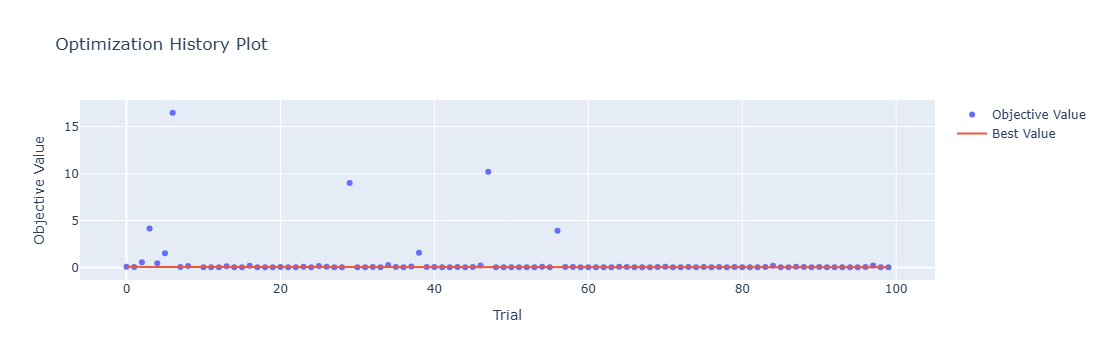

In [4]:
optuna.visualization.plot_optimization_history(study)

[W 2025-05-17 05:32:25,716] Trial 9 is omitted in visualization because its objective value is inf or nan.


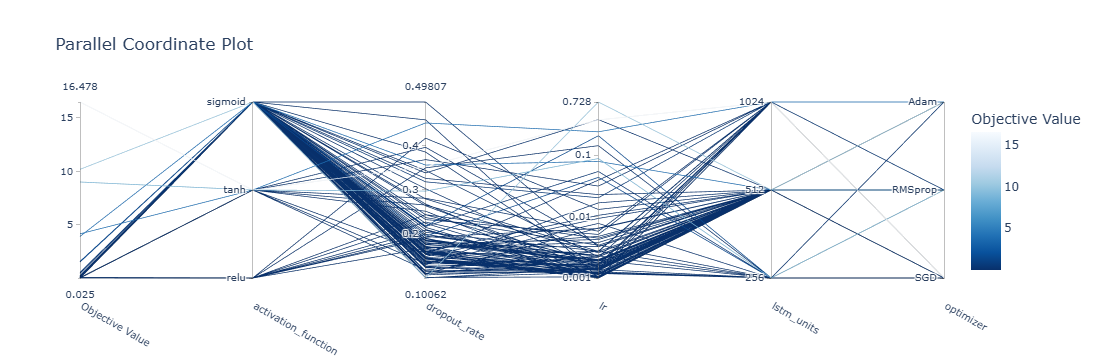

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

[W 2025-05-17 05:32:45,523] Trial 9 is omitted in visualization because its objective value is inf or nan.


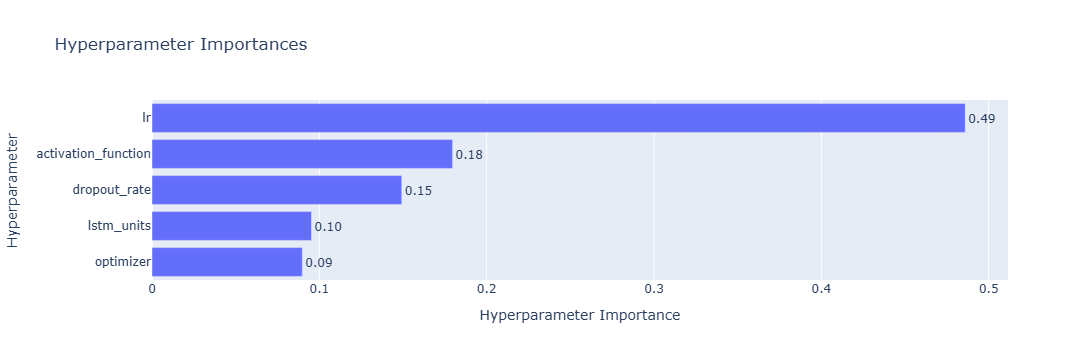

In [6]:
optuna.visualization.plot_param_importances(study)

[W 2025-05-17 05:32:56,828] Trial 9 is omitted in visualization because its objective value is inf or nan.


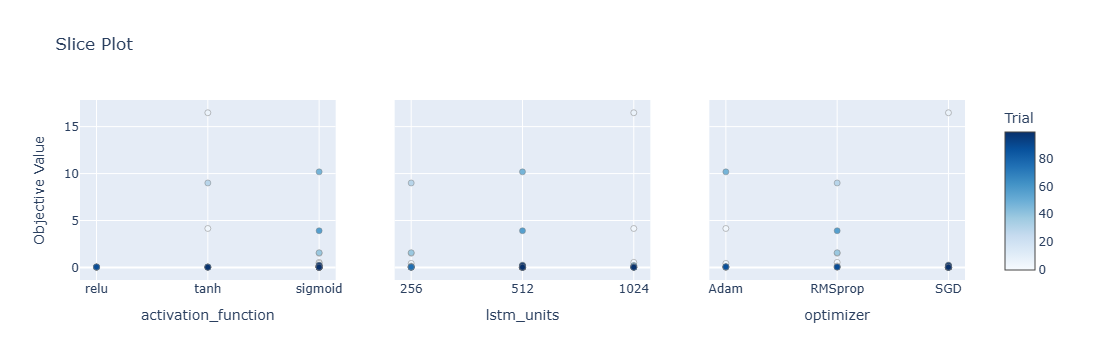

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

[W 2025-05-17 05:33:03,157] Trial 9 is omitted in visualization because its objective value is inf or nan.


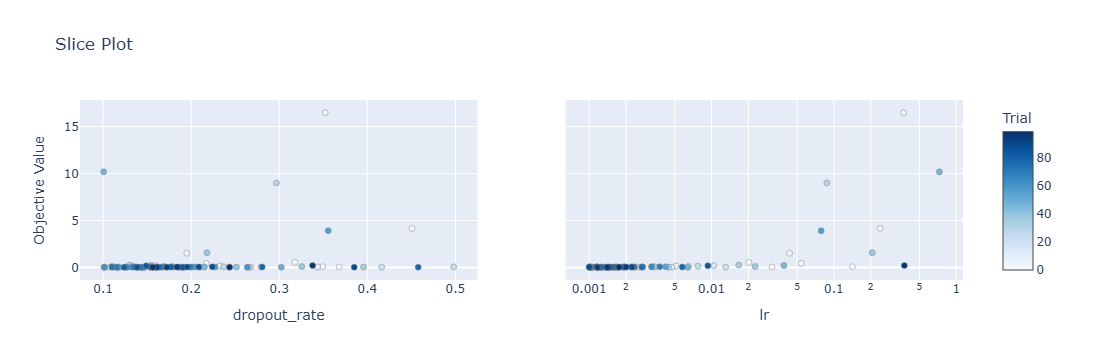

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[ 5.39  4.3   6.51 ... 13.73  8.35  9.05]
 [ 8.03  6.78  8.21 ... 17.14 11.74 12.27]
 [ 5.48  4.27  5.49 ... 13.3   9.17  8.6 ]
 ...
 [ 4.55  3.1   4.22 ... 12.8   7.91  6.65]
 [ 4.44  3.4   5.39 ... 12.34  7.74  6.78]
 [ 4.14  2.75  4.12 ... 10.6   7.07  6.41]]
Epoch 1/100
84/84 [==============================] - 33s 219ms/step - loss: 0.0359 - accuracy: 0.0000e+00 - mae: 0.0359 - rmse: 0.0359 - mape: 7.2205 - pearson: nan - val_loss: 0.0874 - val_accuracy: 0.0000e+00 - val_mae: 0.0874 - val_rmse: 0.0874 - val_mape: 18.1599 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 10s 124ms/step - loss: 0.0344 - accuracy: 0.0000e+00 - mae: 0.0344 - rmse: 0.0344 - mape: 6.9587 - pearson: nan - val_loss: 0.0873 - val_accuracy: 0.0000e+00 - val_mae: 0.0873 - val_rmse: 0.0873 - val_mape: 18.1262 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 10s 123ms/step - loss: 0.0349 - accuracy: 0.0000e+00 - mae: 0.0349 - rmse: 0.0349 - mape: 7.0756 - pearson: n

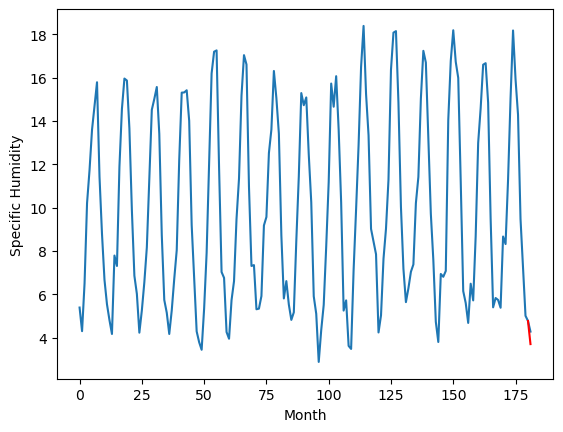

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.74		4.95		-0.79
[180, 181]
[7.05, 4.9516324245929715]


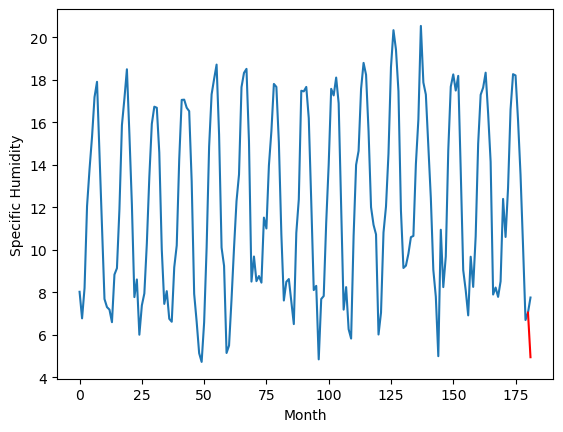

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.41		7.59		-0.82
[180, 181]
[5.06, 7.588253020048141]


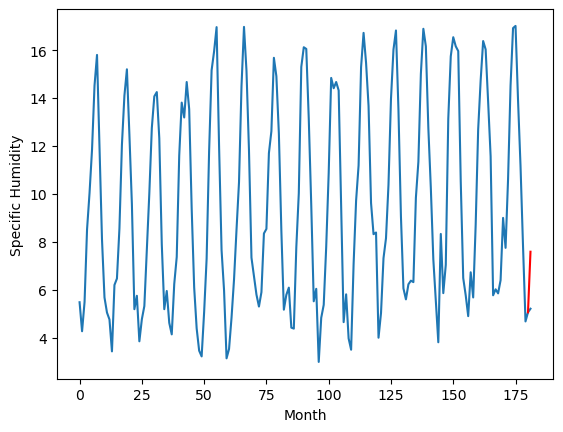

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.55		5.04		-0.51
[180, 181]
[7.05, 5.04295594573021]


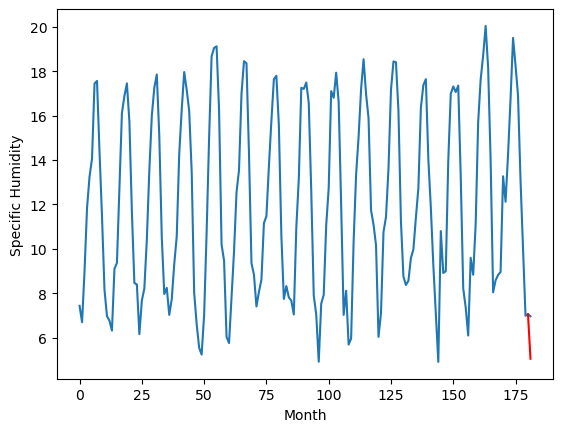

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.36		6.99		-0.37
[180, 181]
[5.2, 6.992128871679306]


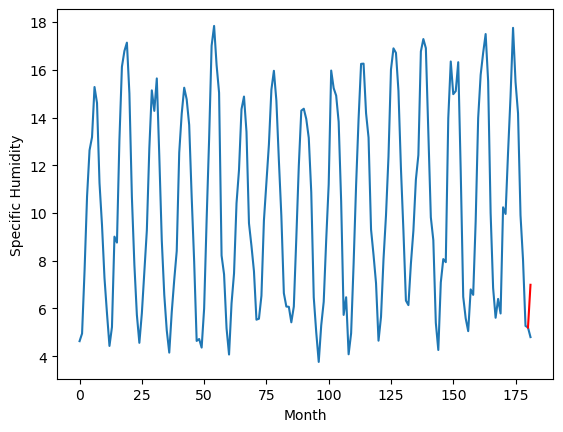

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.02		4.18		0.16
[180, 181]
[5.16, 4.184174154996872]


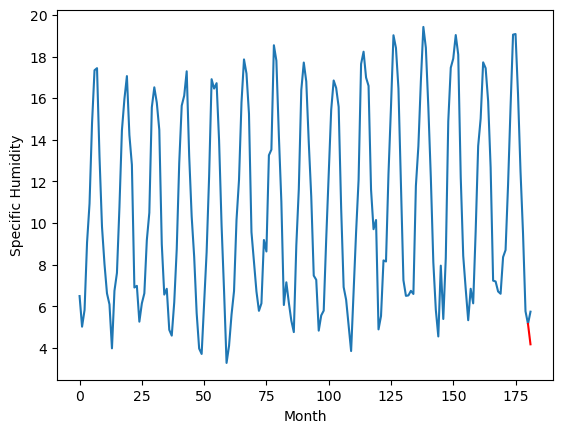

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.35		6.05		-0.30
[180, 181]
[4.05, 6.051937013864517]


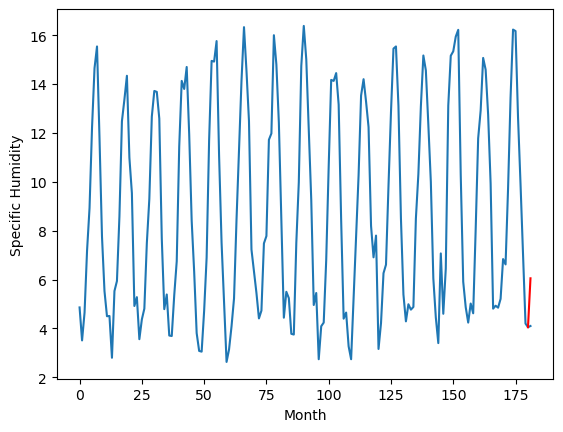

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.55		4.41		-0.14
[180, 181]
[3.64, 4.411234632730484]


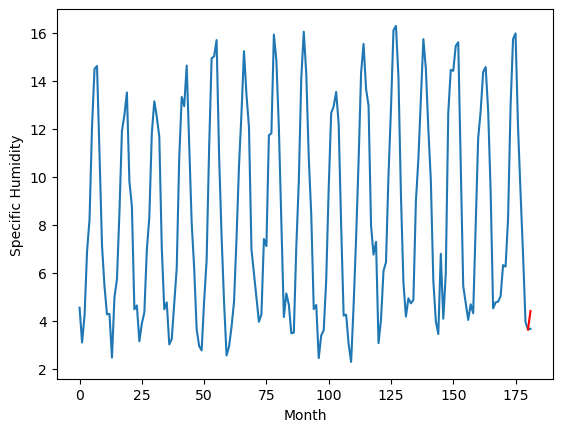

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.32		4.11		-0.21
[180, 181]
[3.46, 4.10844783782959]


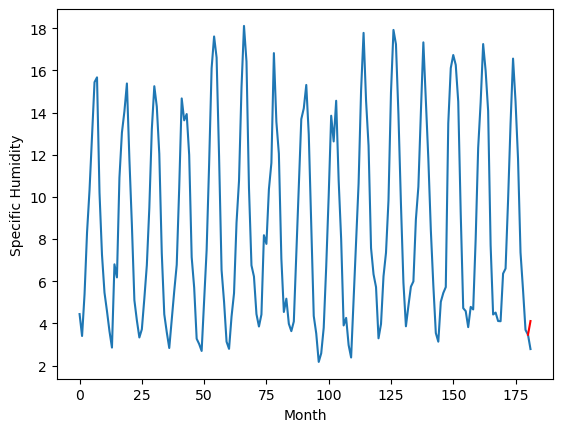

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.11		3.99		-0.12
[180, 181]
[2.93, 3.994470479488373]


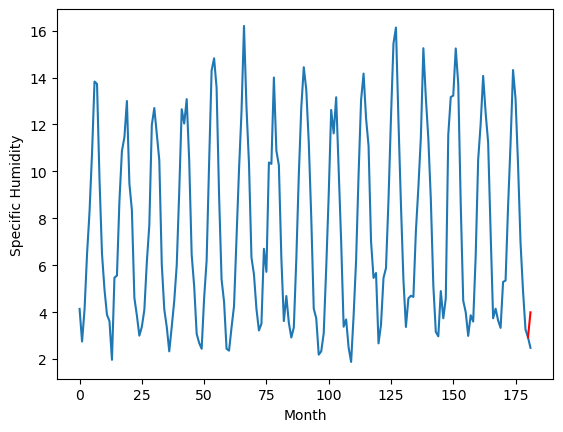

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.76		3.70		-0.06
[180, 181]
[2.74, 3.6959975206851956]


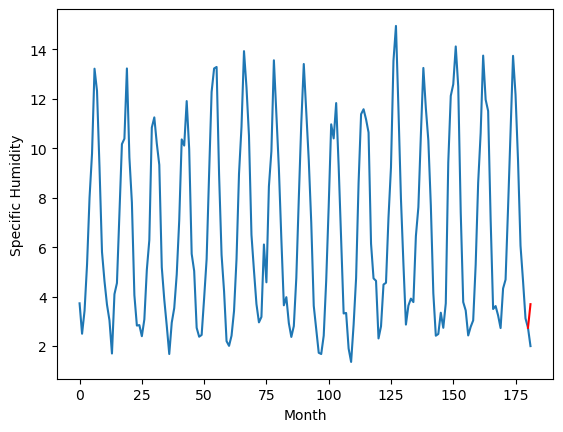

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    3.90   3.702834
1                 1    5.74   4.951632
2                 2    8.41   7.588253
3                 3    5.55   5.042956
4                 4    7.36   6.992129
5                 5    4.02   4.184174
6                 6    6.35   6.051937
7                 7    4.55   4.411235
8                 8    4.32   4.108448
9                 9    4.11   3.994470
10               10    3.76   3.695998


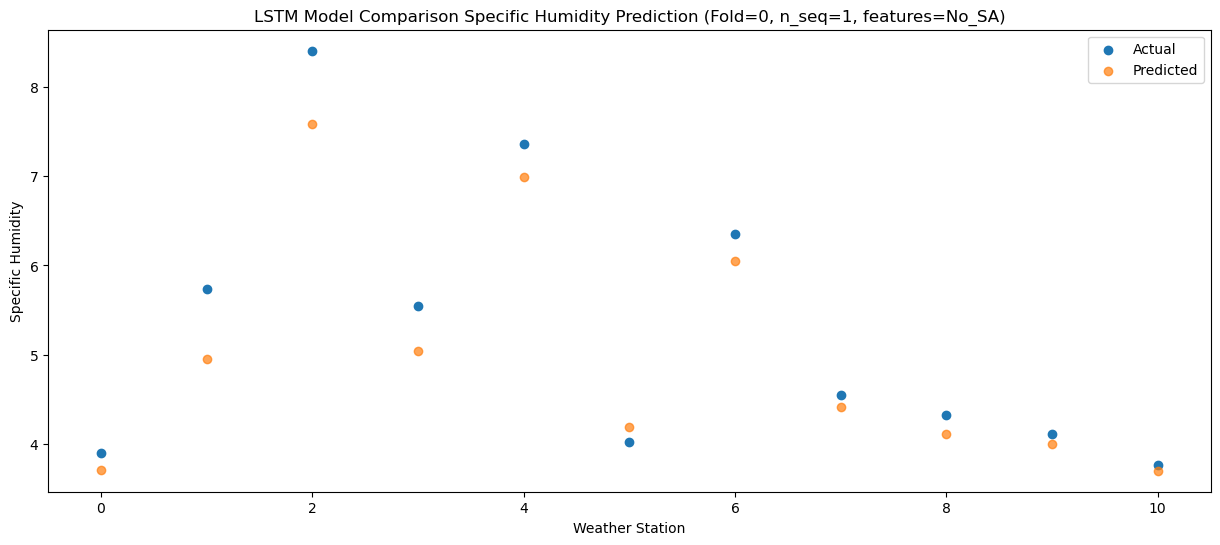

f, t:
[[3.9  5.74 8.41 5.55 7.36 4.02 6.35 4.55 4.32 4.11 3.76]]
[[3.70283367 4.95163242 7.58825302 5.04295595 6.99212887 4.18417415
  6.05193701 4.41123463 4.10844784 3.99447048 3.69599752]]
Year at t+1:
t+1 SKRMSE: 0.418367
t+1 KRMSE: 0.418367
t+1 MAE: 0.334026
t+1 SKMAPE: 0.058121
t+1 R2_SCORE: 0.920370
t+1 KMAPE: 0.058121
t+1 PEARSON: 0.978612
t+1 AVERAGE ACTUAL: 5.279091
Metrics for this Fold:
SKRMSE: 0.418367
KRMSE: 0.418367
MAE: 0.334026
SKMAPE: 0.058121
R2_SCORE: 0.920370
KMAPE: 0.058121
PEARSON: 0.978612
AVERAGE ACTUAL: 5.279091
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1, 512)               5083136   
                                                                 
 dropout (Dropout)           (1, 1, 512)               0         
                                                                 
 lstm_1 (LSTM)               (1, 512)   

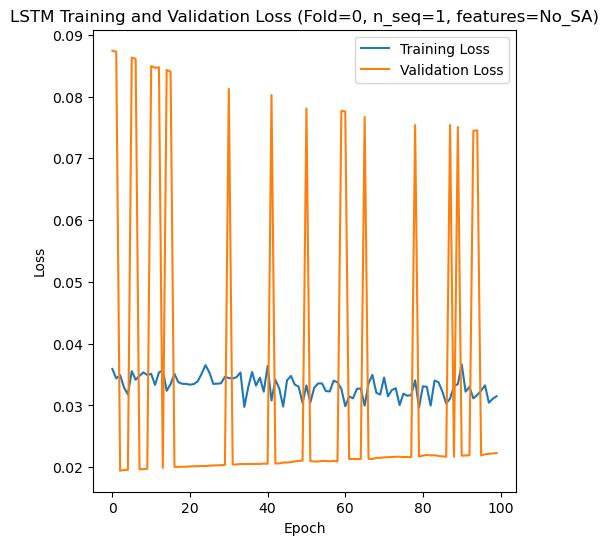

[[ 6.43  5.26  5.95 ... 15.04 10.09  9.76]
 [ 4.92  3.81  4.91 ... 12.52  8.69  7.9 ]
 [ 5.77  4.38  5.81 ... 14.28  9.78  9.52]
 ...
 [ 4.32  3.52  5.54 ... 12.    6.96  7.01]
 [ 3.07  3.12  5.08 ... 11.47  8.11  7.14]
 [ 2.37  2.06  3.5  ...  9.32  6.33  5.39]]
Epoch 1/100
84/84 [==============================] - 40s 249ms/step - loss: 0.1034 - accuracy: 0.0000e+00 - mae: 0.1034 - rmse: 0.1034 - mape: 20.6802 - pearson: nan - val_loss: 0.0153 - val_accuracy: 0.0000e+00 - val_mae: 0.0153 - val_rmse: 0.0153 - val_mape: 3.1115 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 13s 156ms/step - loss: 0.0337 - accuracy: 0.0000e+00 - mae: 0.0337 - rmse: 0.0337 - mape: 6.8233 - pearson: nan - val_loss: 0.0153 - val_accuracy: 0.0000e+00 - val_mae: 0.0153 - val_rmse: 0.0153 - val_mape: 3.1203 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 14s 161ms/step - loss: 0.0348 - accuracy: 0.0000e+00 - mae: 0.0348 - rmse: 0.0348 - mape: 7.1066 - pearson: na

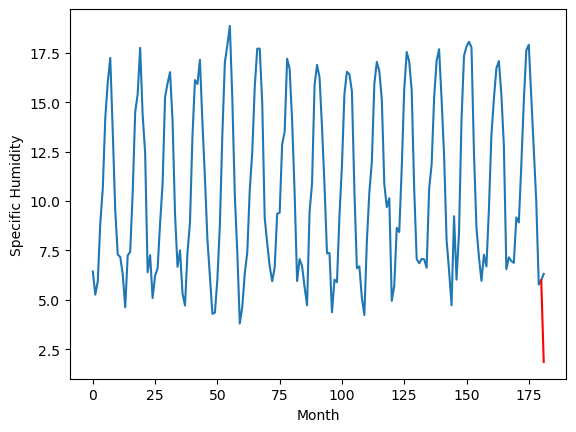

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.45		5.92		-0.53
[180, 181]
[4.15, 5.915641479492187]


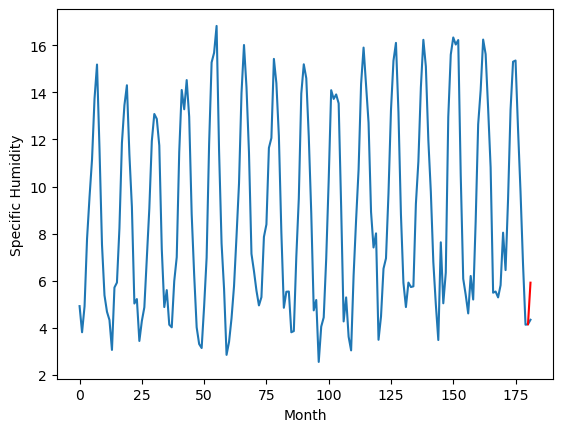

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.07		4.41		-0.66
[180, 181]
[5.12, 4.406337542533874]


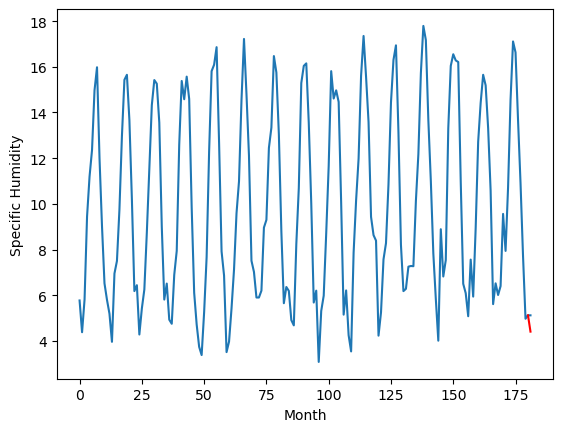

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.43		5.25		-0.18
[180, 181]
[6.35, 5.254522402286529]


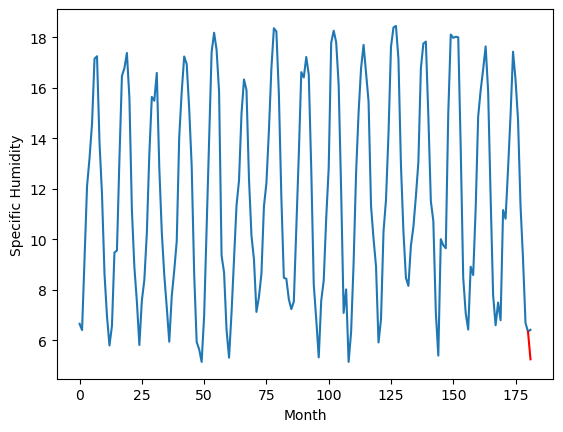

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.41		6.15		-0.26
[180, 181]
[6.08, 6.146031532287598]


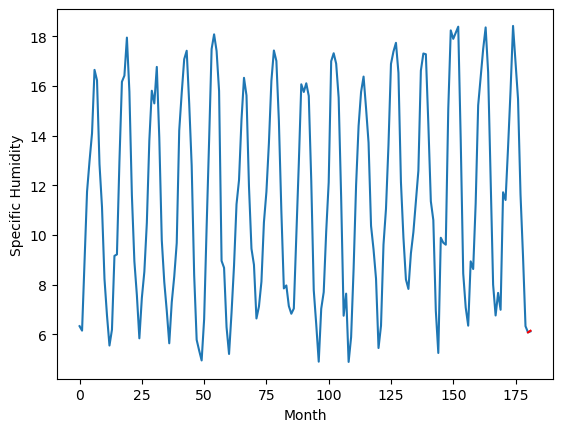

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.16		5.82		-1.34
[180, 181]
[3.92, 5.816391186714172]


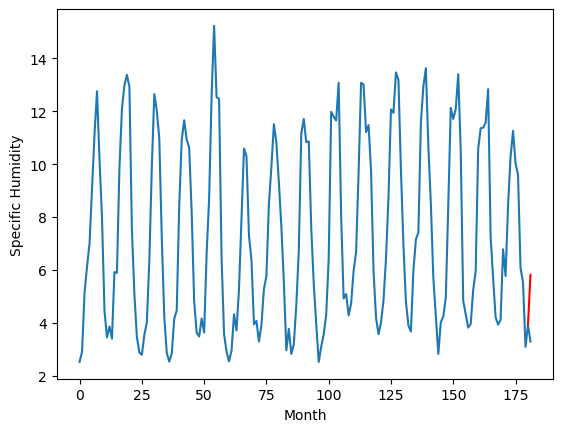

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.41		2.00		-0.41
[180, 181]
[4.16, 2.001640875339508]


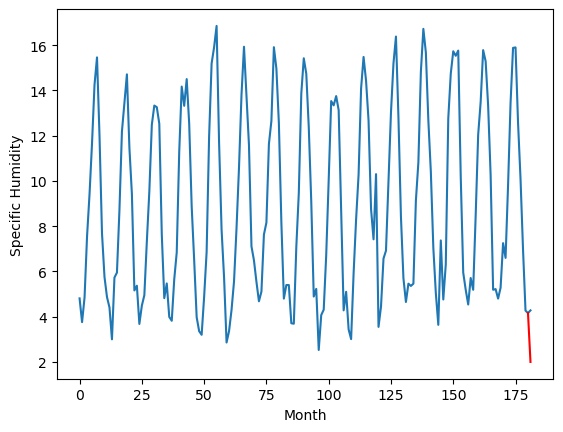

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.68		4.29		-0.39
[180, 181]
[3.84, 4.288348016738891]


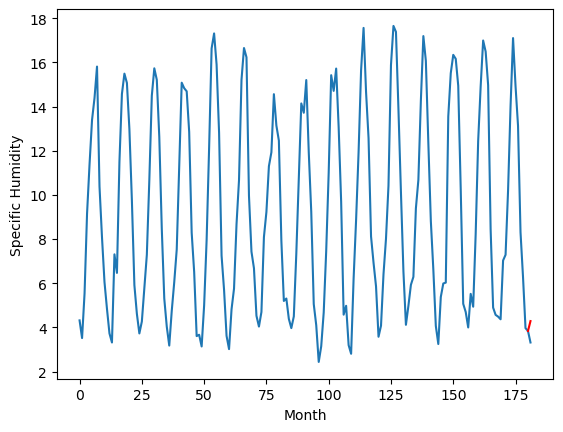

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.48		3.80		-0.68
[180, 181]
[3.73, 3.7958706092834475]


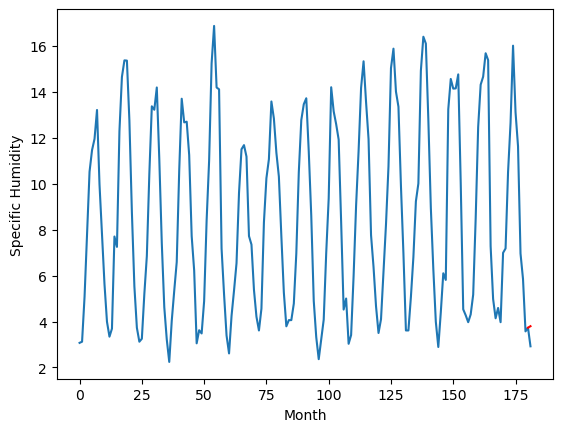

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.26		2.55		-0.71
[180, 181]
[2.83, 2.5472772789001463]


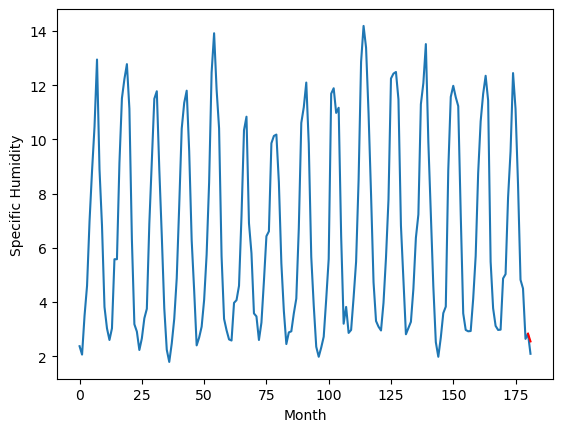

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
1.64		1.85		0.21
[180, 181]
[2.69, 1.851096088886261]


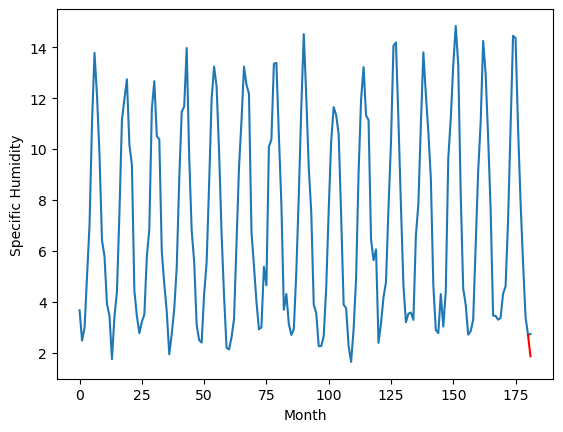

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    2.59   1.856557
1                 1    6.45   5.915641
2                 2    5.07   4.406338
3                 3    5.43   5.254522
4                 4    6.41   6.146032
5                 5    7.16   5.816391
6                 6    2.41   2.001641
7                 7    4.68   4.288348
8                 8    4.48   3.795871
9                 9    3.26   2.547277
10               10    1.64   1.851096


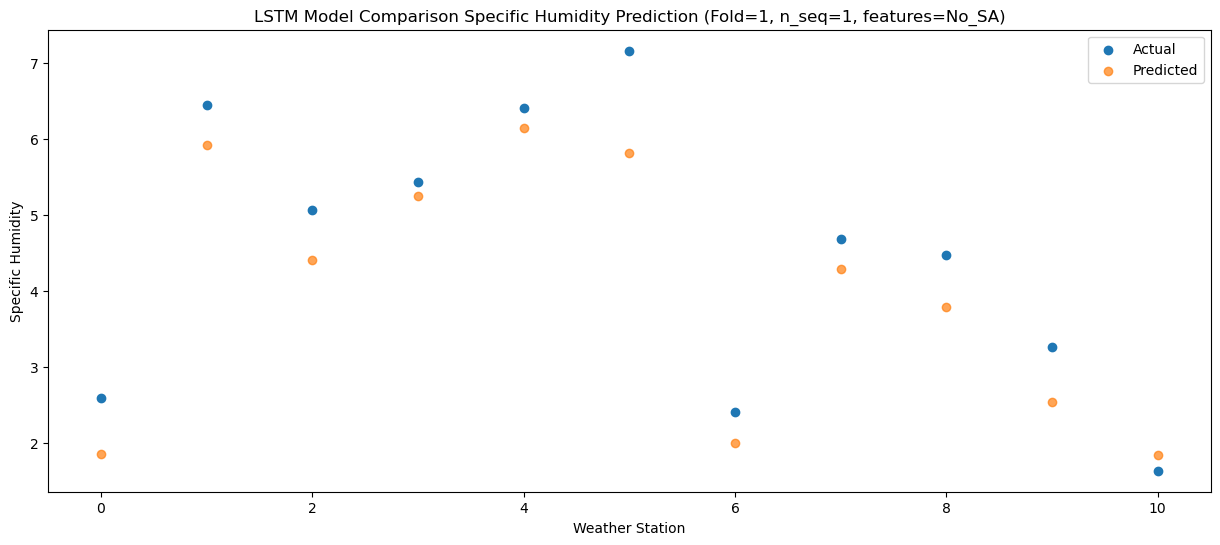

f, t:
[[2.59 6.45 5.07 5.43 6.41 7.16 2.41 4.68 4.48 3.26 1.64]]
[[1.85655653 5.91564148 4.40633754 5.2545224  6.14603153 5.81639119
  2.00164088 4.28834802 3.79587061 2.54727728 1.85109609]]
Year at t+1:
t+1 SKRMSE: 0.640341
t+1 KRMSE: 0.640341
t+1 MAE: 0.556589
t+1 SKMAPE: 0.137387
t+1 R2_SCORE: 0.865287
t+1 KMAPE: 0.137387
t+1 PEARSON: 0.956126
t+1 AVERAGE ACTUAL: 4.507273
Metrics for this Fold:
SKRMSE: 0.640341
KRMSE: 0.640341
MAE: 0.556589
SKMAPE: 0.137387
R2_SCORE: 0.865287
KMAPE: 0.137387
PEARSON: 0.956126
AVERAGE ACTUAL: 4.507273
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (1, 1, 512)               5083136   
                                                                 
 dropout_2 (Dropout)         (1, 1, 512)               0         
                                                                 
 lstm_3 (LSTM)               (1, 512) 

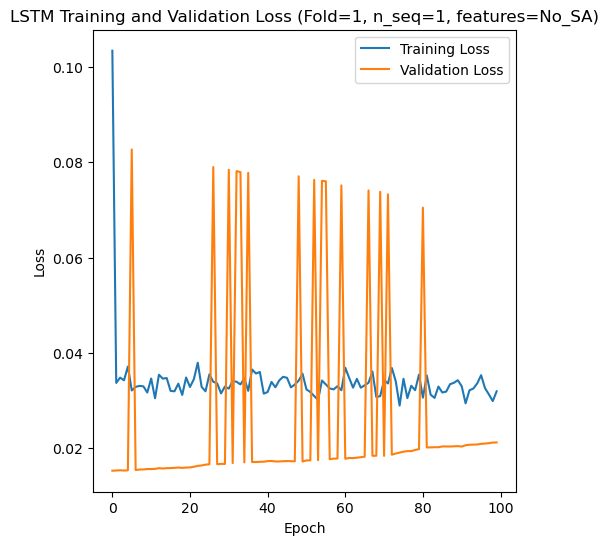

[[ 4.97  3.84  5.83 ... 12.86  8.48  8.25]
 [ 2.46  2.06  3.48 ...  9.57  6.71  5.1 ]
 [ 8.78  8.15  9.01 ... 20.36 15.38 12.95]
 ...
 [ 1.89  2.51  2.73 ...  7.42  4.53  3.35]
 [ 5.04  4.9   5.93 ... 10.09  8.19  4.88]
 [ 5.06  3.79  4.84 ... 13.58  8.96  7.8 ]]
Epoch 1/100
84/84 [==============================] - 44s 230ms/step - loss: 0.3476 - accuracy: 0.0000e+00 - mae: 0.3476 - rmse: 0.3476 - mape: 70.6521 - pearson: nan - val_loss: 0.0195 - val_accuracy: 0.0000e+00 - val_mae: 0.0195 - val_rmse: 0.0195 - val_mape: 4.2009 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 13s 159ms/step - loss: 0.0296 - accuracy: 0.0000e+00 - mae: 0.0296 - rmse: 0.0296 - mape: 5.9273 - pearson: nan - val_loss: 0.0191 - val_accuracy: 0.0000e+00 - val_mae: 0.0191 - val_rmse: 0.0191 - val_mape: 4.1215 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 13s 153ms/step - loss: 0.0296 - accuracy: 0.0000e+00 - mae: 0.0296 - rmse: 0.0296 - mape: 5.9418 - pearson: na

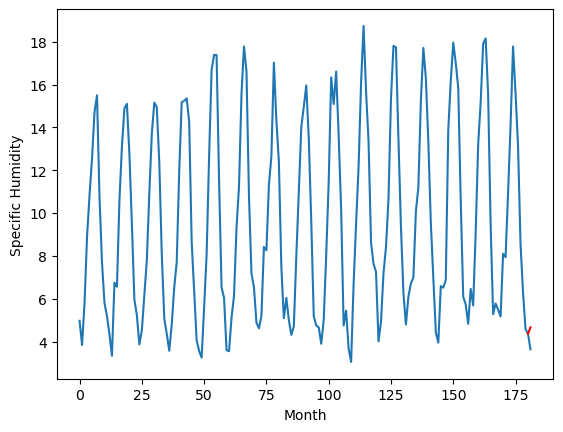

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.92		4.58		-0.34
[180, 181]
[2.82, 4.582462371587753]


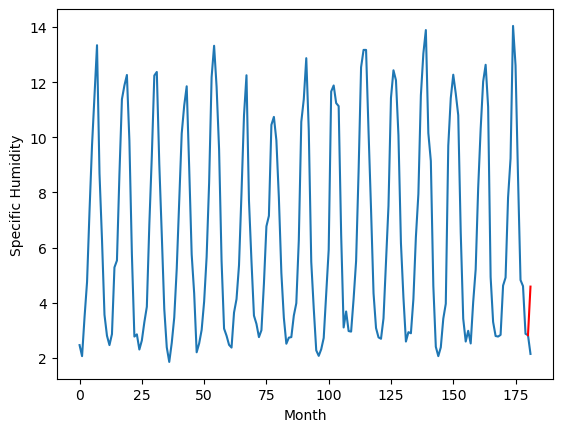

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.95		2.08		-0.87
[180, 181]
[9.16, 2.0767951822280883]


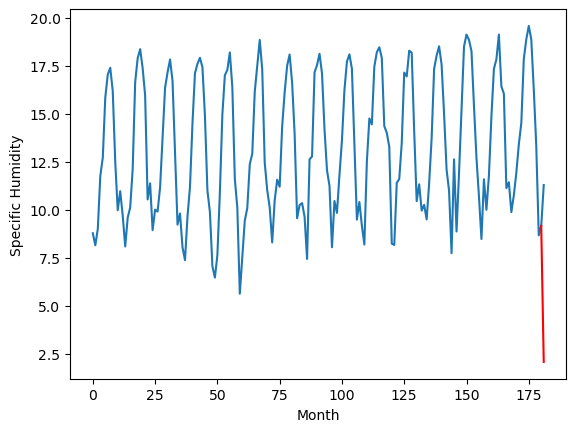

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.70		8.39		0.69
[180, 181]
[2.44, 8.388794778585433]


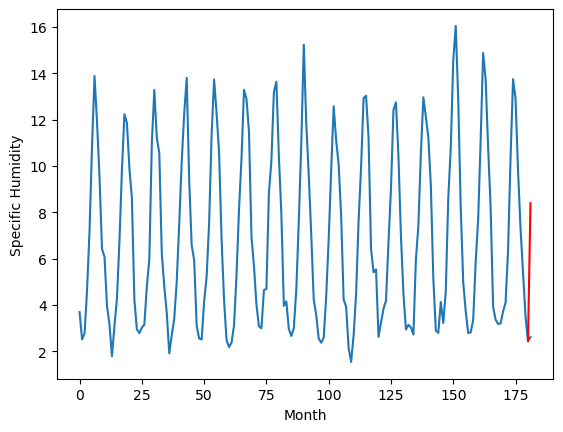

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.82		3.30		-0.52
[180, 181]
[6.65, 3.3014111244678497]


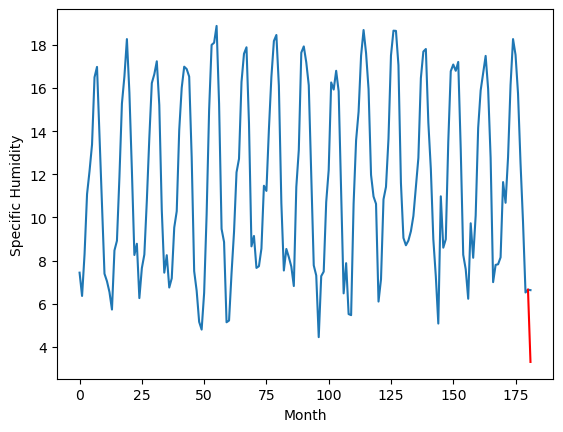

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.31		7.05		-0.26
[180, 181]
[6.19, 7.045199009180069]


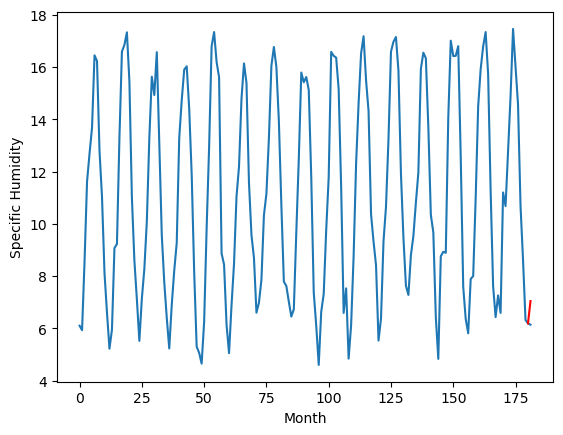

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.00		5.70		-0.30
[180, 181]
[4.78, 5.703164553642273]


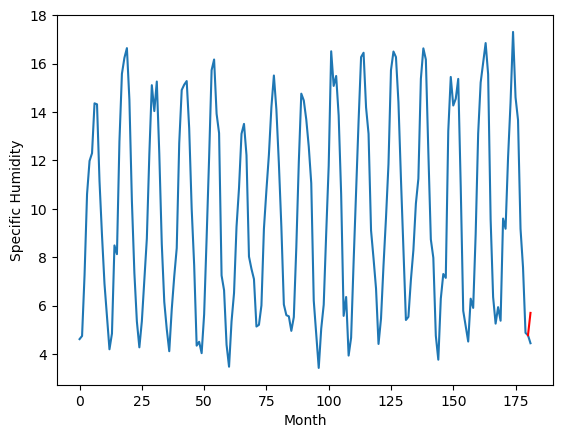

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.90		4.23		-0.67
[180, 181]
[2.61, 4.228906358480454]


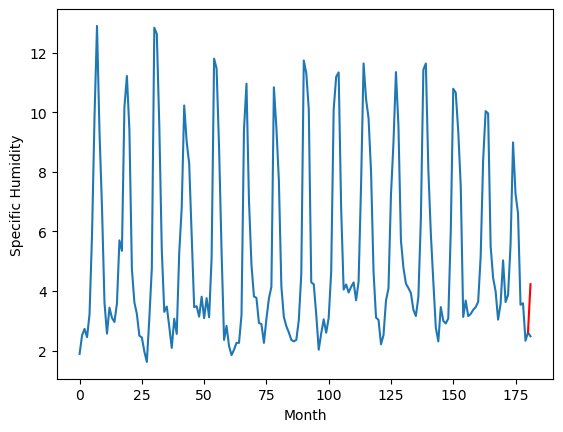

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.74		1.50		-1.24
[180, 181]
[4.6, 1.500125720500946]


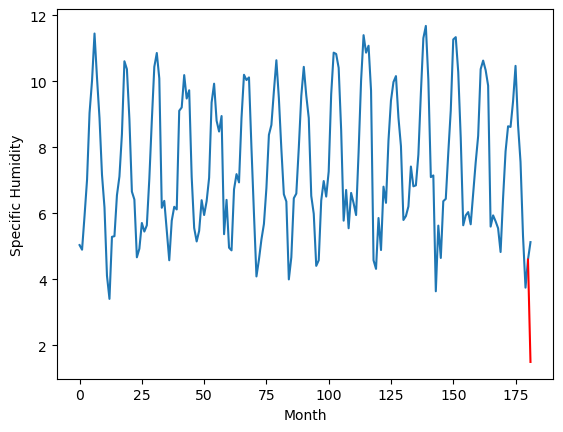

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.92		4.64		-0.28
[180, 181]
[4.27, 4.642796256542206]


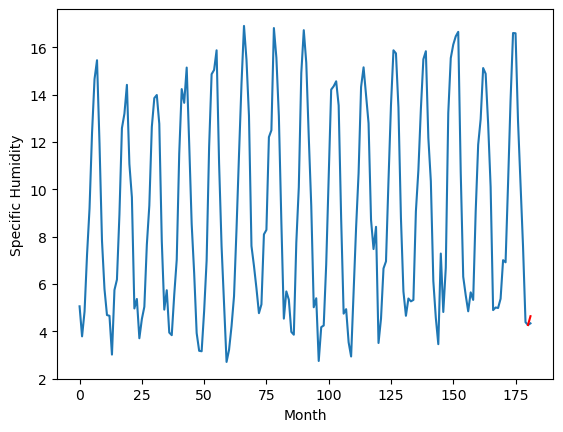

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.07		4.66		-0.41
[180, 181]
[3.91, 4.663163599967956]


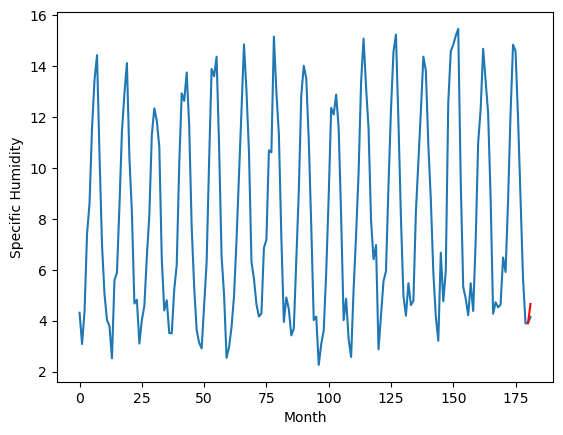

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    4.83   4.666313
1                 1    4.92   4.582462
2                 2    2.95   2.076795
3                 3    7.70   8.388795
4                 4    3.82   3.301411
5                 5    7.31   7.045199
6                 6    6.00   5.703165
7                 7    4.90   4.228906
8                 8    2.74   1.500126
9                 9    4.92   4.642796
10               10    5.07   4.663164


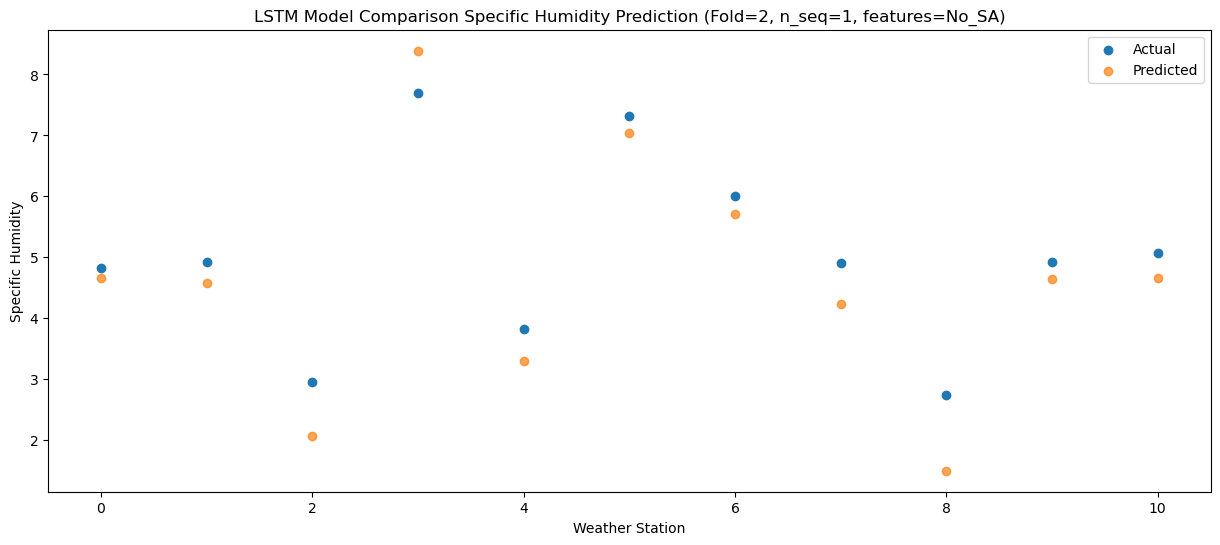

f, t:
[[4.83 4.92 2.95 7.7  3.82 7.31 6.   4.9  2.74 4.92 5.07]]
[[4.66631299 4.58246237 2.07679518 8.38879478 3.30141112 7.04519901
  5.70316455 4.22890636 1.50012572 4.64279626 4.6631636 ]]
Year at t+1:
t+1 SKRMSE: 0.605642
t+1 KRMSE: 0.605642
t+1 MAE: 0.521678
t+1 SKMAPE: 0.130496
t+1 R2_SCORE: 0.834522
t+1 KMAPE: 0.130496
t+1 PEARSON: 0.983221
t+1 AVERAGE ACTUAL: 5.014545
Metrics for this Fold:
SKRMSE: 0.605642
KRMSE: 0.605642
MAE: 0.521678
SKMAPE: 0.130496
R2_SCORE: 0.834522
KMAPE: 0.130496
PEARSON: 0.983221
AVERAGE ACTUAL: 5.014545
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (1, 1, 512)               5083136   
                                                                 
 dropout_4 (Dropout)         (1, 1, 512)               0         
                                                                 
 lstm_5 (LSTM)               (1, 512) 

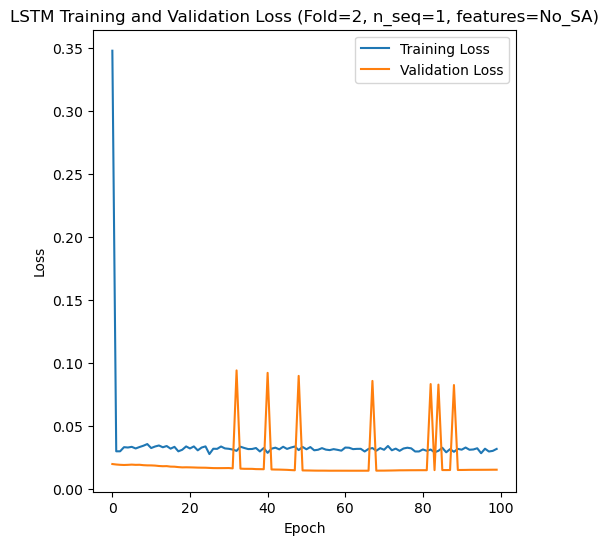

[[ 5.11  3.7   4.74 ... 13.5   8.68  7.66]
 [ 3.73  2.91  5.05 ... 11.19  6.96  6.57]
 [ 5.56  5.41  5.55 ...  8.56  7.45  5.59]
 ...
 [ 2.73  2.21  3.23 ...  5.    3.95  3.09]
 [ 5.93  5.59  5.49 ...  8.63  7.04  6.11]
 [ 3.71  2.55  2.84 ...  9.78  6.68  4.77]]
Epoch 1/100
84/84 [==============================] - 44s 247ms/step - loss: 0.0727 - accuracy: 0.0000e+00 - mae: 0.0727 - rmse: 0.0727 - mape: 14.7027 - pearson: nan - val_loss: 0.0294 - val_accuracy: 0.0000e+00 - val_mae: 0.0294 - val_rmse: 0.0294 - val_mape: 5.9388 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 13s 159ms/step - loss: 0.0312 - accuracy: 0.0000e+00 - mae: 0.0312 - rmse: 0.0312 - mape: 6.2792 - pearson: nan - val_loss: 0.0295 - val_accuracy: 0.0000e+00 - val_mae: 0.0295 - val_rmse: 0.0295 - val_mape: 5.9503 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 13s 155ms/step - loss: 0.0316 - accuracy: 0.0000e+00 - mae: 0.0316 - rmse: 0.0316 - mape: 6.4217 - pearson: na

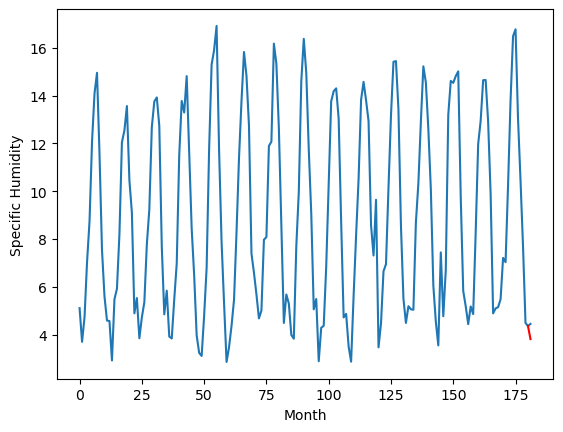

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.02		5.22		0.20
[180, 181]
[3.43, 5.2165683811903]


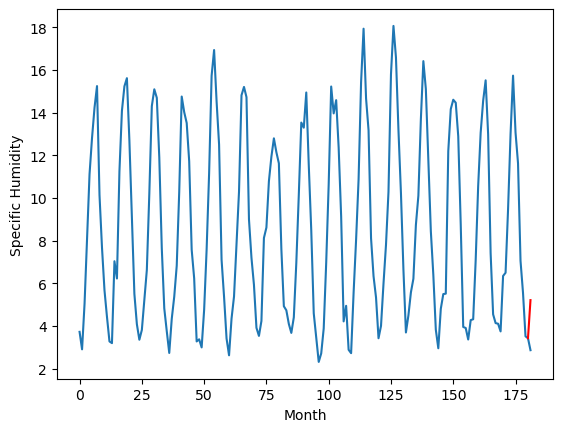

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.17		3.84		-0.33
[180, 181]
[5.43, 3.8399385991692543]


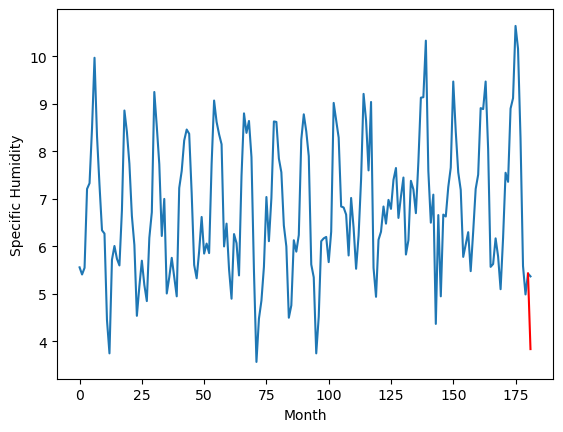

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.29		5.66		0.37
[180, 181]
[3.21, 5.662571681141853]


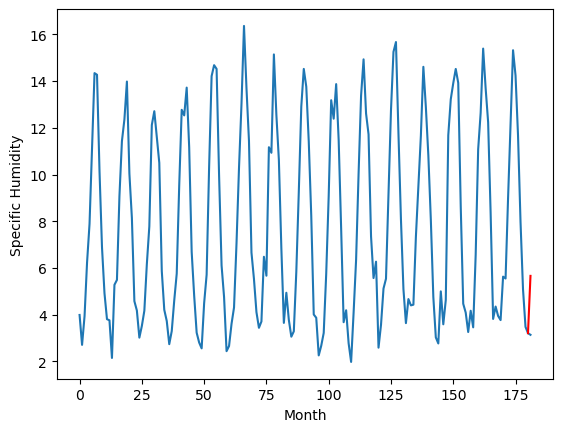

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.79		4.09		0.30
[180, 181]
[3.04, 4.092911025285721]


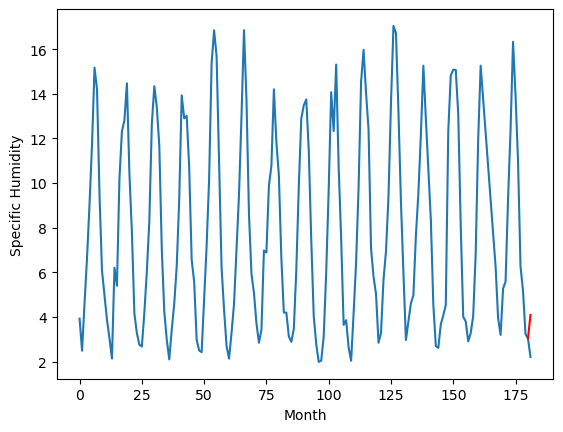

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.62		4.03		0.41
[180, 181]
[2.91, 4.0293561446666715]


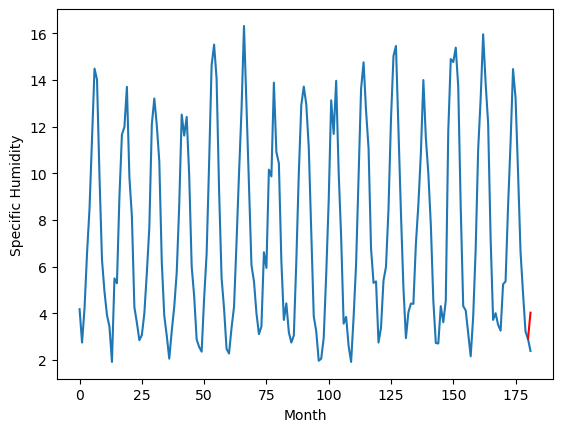

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.35		4.28		-0.07
[180, 181]
[1.6, 4.284180417954921]


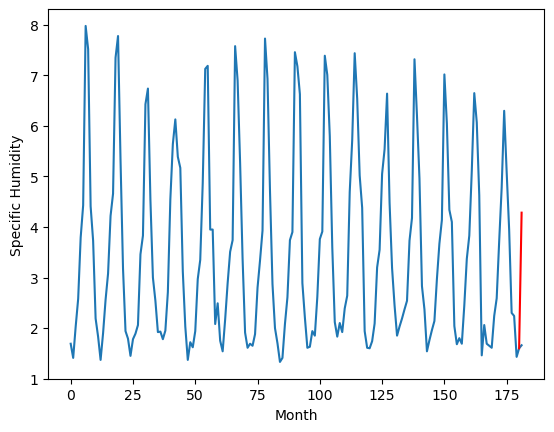

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.50		1.79		-0.71
[180, 181]
[2.86, 1.7946019345521926]


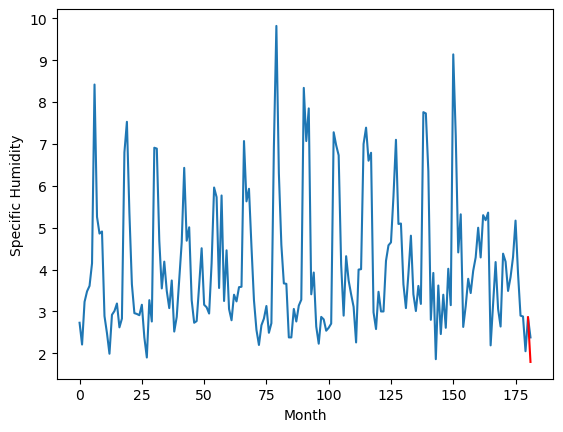

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.40		2.84		-0.56
[180, 181]
[5.65, 2.836578044593334]


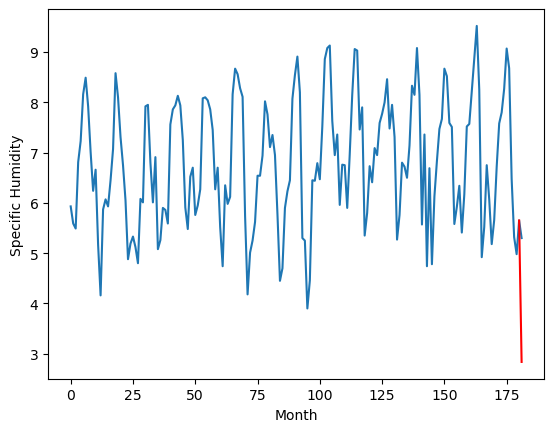

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.84		6.04		1.20
[180, 181]
[2.54, 6.035123996734619]


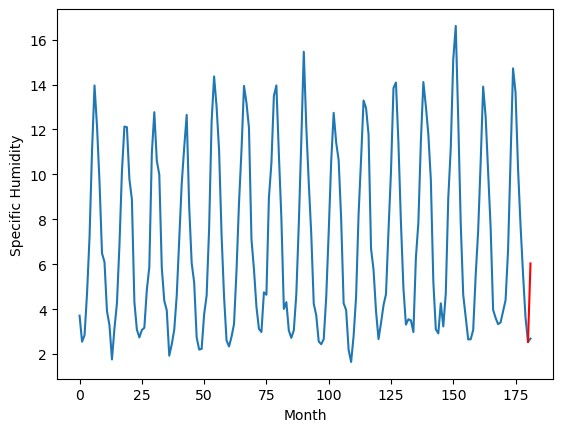

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.02		3.81		0.79
[180, 181]
[2.51, 3.812895550429821]


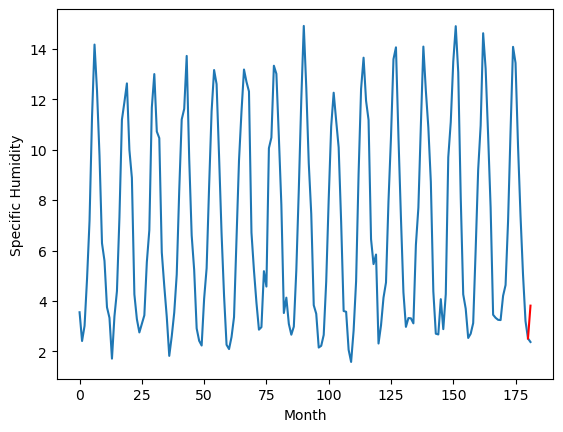

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    3.58   3.814282
1                 1    5.02   5.216568
2                 2    4.17   3.839939
3                 3    5.29   5.662572
4                 4    3.79   4.092911
5                 5    3.62   4.029356
6                 6    4.35   4.284180
7                 7    2.50   1.794602
8                 8    3.40   2.836578
9                 9    4.84   6.035124
10               10    3.02   3.812896


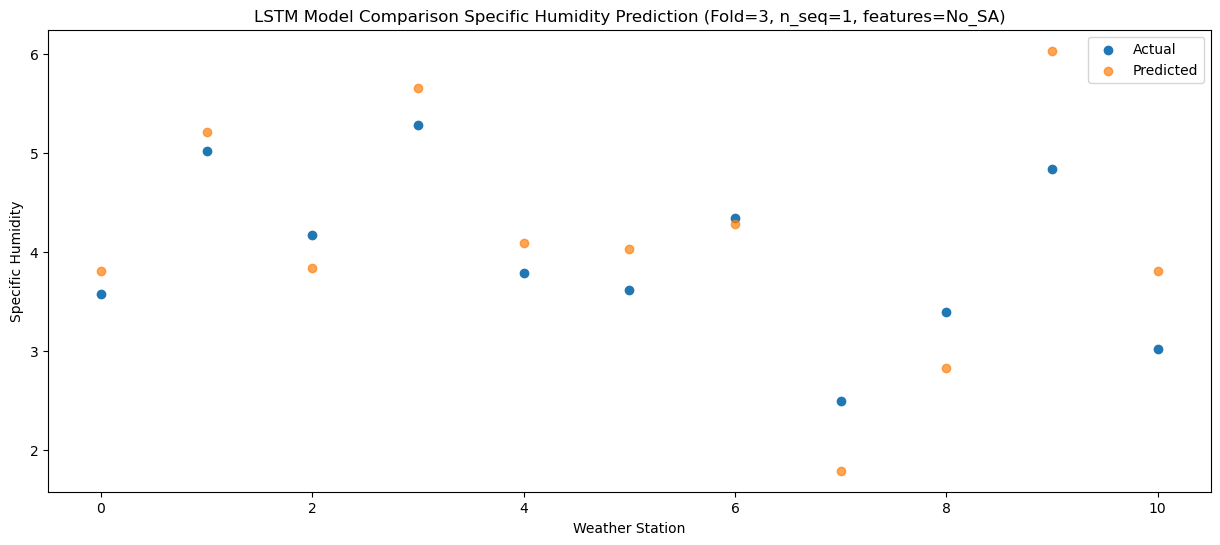

f, t:
[[3.58 5.02 4.17 5.29 3.79 3.62 4.35 2.5  3.4  4.84 3.02]]
[[3.81428192 5.21656838 3.8399386  5.66257168 4.09291103 4.02935614
  4.28418042 1.79460193 2.83657804 6.035124   3.81289555]]
Year at t+1:
t+1 SKRMSE: 0.562217
t+1 KRMSE: 0.562217
t+1 MAE: 0.469855
t+1 SKMAPE: 0.129060
t+1 R2_SCORE: 0.535212
t+1 KMAPE: 0.129060
t+1 PEARSON: 0.818788
t+1 AVERAGE ACTUAL: 3.961818
Metrics for this Fold:
SKRMSE: 0.562217
KRMSE: 0.562217
MAE: 0.469855
SKMAPE: 0.129060
R2_SCORE: 0.535212
KMAPE: 0.129060
PEARSON: 0.818788
AVERAGE ACTUAL: 3.961818
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (1, 1, 512)               5083136   
                                                                 
 dropout_6 (Dropout)         (1, 1, 512)               0         
                                                                 
 lstm_7 (LSTM)               (1, 512) 

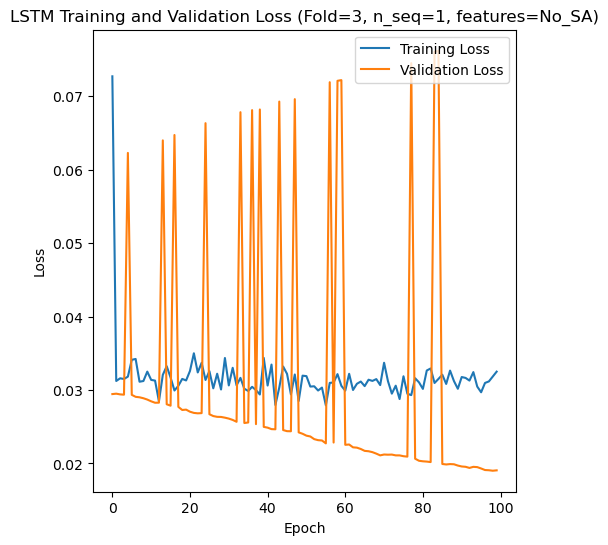

[[ 3.4   2.19  4.28 ... 10.54  6.41  5.39]
 [ 7.94  7.22  7.86 ... 18.27 13.85 11.85]
 [ 5.92  4.91  6.84 ... 14.38  9.59 10.48]
 ...
 [ 3.92  3.    4.93 ... 11.51  7.19  6.46]
 [ 3.98  2.61  4.   ... 10.23  6.65  5.8 ]
 [ 3.84  2.35  4.25 ... 10.6   6.5   5.9 ]]
Epoch 1/100
84/84 [==============================] - 44s 231ms/step - loss: 0.4458 - accuracy: 0.0000e+00 - mae: 0.4458 - rmse: 0.4458 - mape: 90.2483 - pearson: nan - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mae: 0.0208 - val_rmse: 0.0208 - val_mape: 4.2001 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 14s 164ms/step - loss: 0.0335 - accuracy: 0.0000e+00 - mae: 0.0335 - rmse: 0.0335 - mape: 6.7879 - pearson: nan - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mae: 0.0208 - val_rmse: 0.0208 - val_mape: 4.2058 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 13s 157ms/step - loss: 0.0349 - accuracy: 0.0000e+00 - mae: 0.0349 - rmse: 0.0349 - mape: 7.0059 - pearson: na

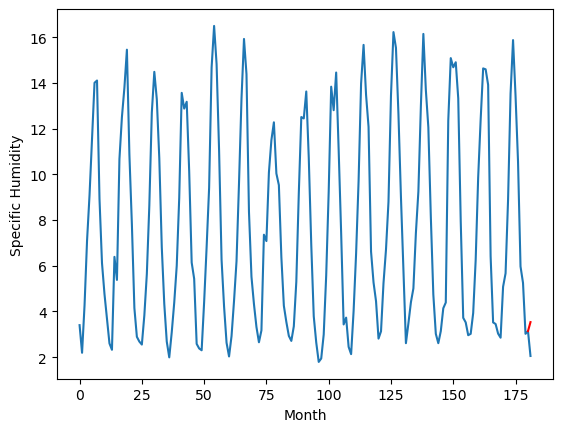

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.75		3.10		-0.65
[180, 181]
[7.79, 3.0992367208003997]


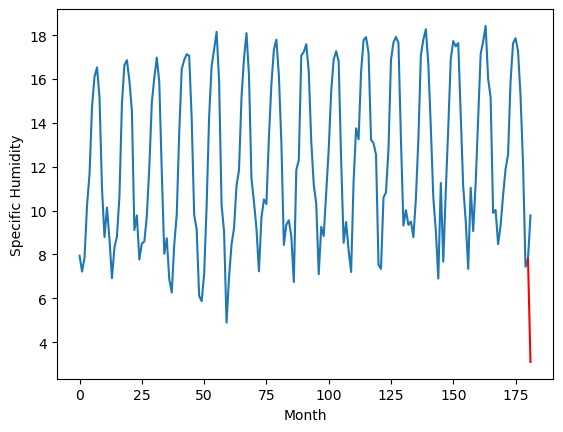

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.83		7.64		-0.19
[180, 181]
[5.03, 7.639016302824021]


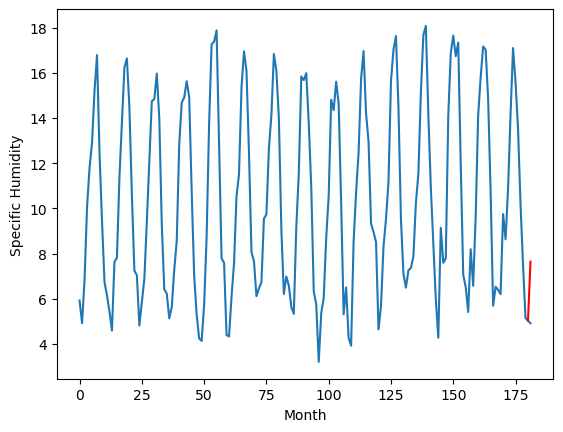

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.81		5.62		-0.19
[180, 181]
[4.41, 5.620684010982513]


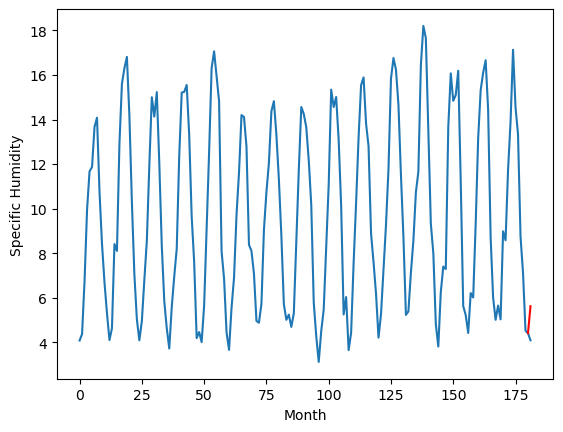

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.04		3.78		-0.26
[180, 181]
[4.29, 3.7813481855392457]


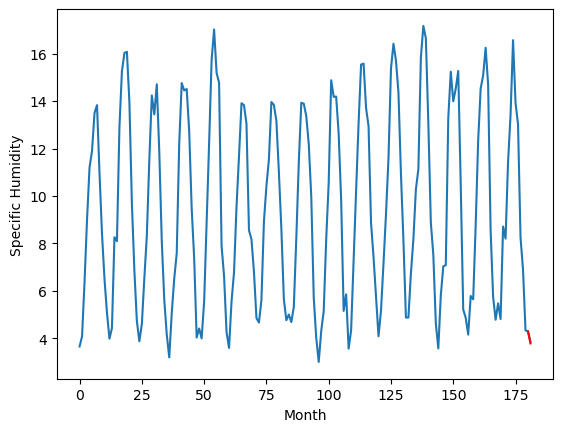

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.35		3.35		-1.00
[180, 181]
[3.47, 3.3529134035110473]


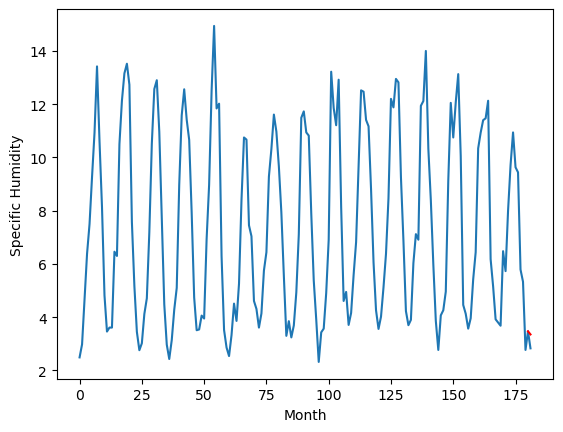

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.37		2.19		-0.18
[180, 181]
[4.52, 2.1885068023204806]


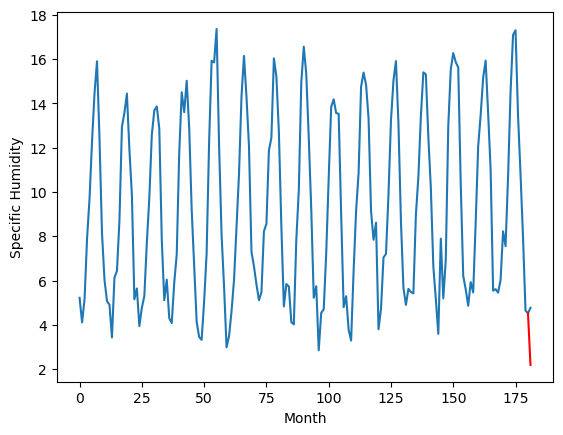

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.07		4.92		-0.15
[180, 181]
[3.4, 4.917045981884002]


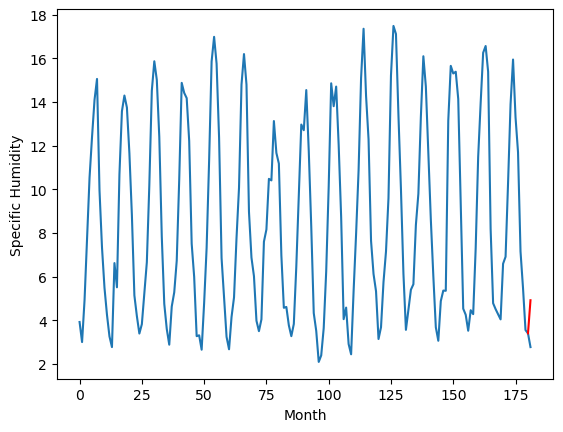

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.57		3.61		0.04
[180, 181]
[2.82, 3.614668650627136]


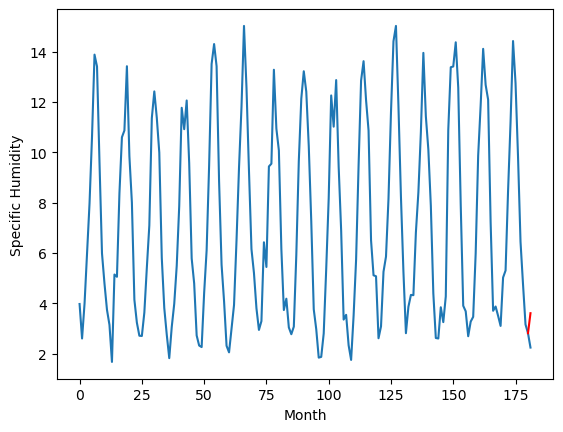

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.66		3.67		0.01
[180, 181]
[2.86, 3.6735607194900513]


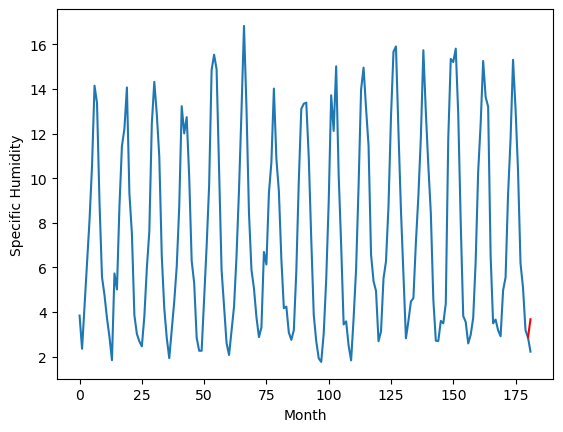

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.46		3.53		0.07
[180, 181]
[2.61, 3.5344008469581603]


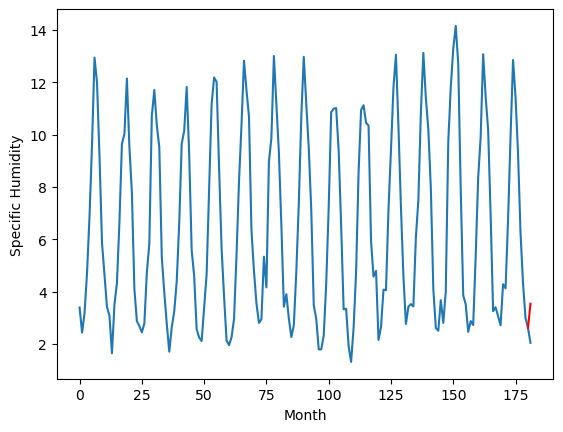

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    3.96   3.532757
1                 1    3.75   3.099237
2                 2    7.83   7.639016
3                 3    5.81   5.620684
4                 4    4.04   3.781348
5                 5    4.35   3.352913
6                 6    2.37   2.188507
7                 7    5.07   4.917046
8                 8    3.57   3.614669
9                 9    3.66   3.673561
10               10    3.46   3.534401


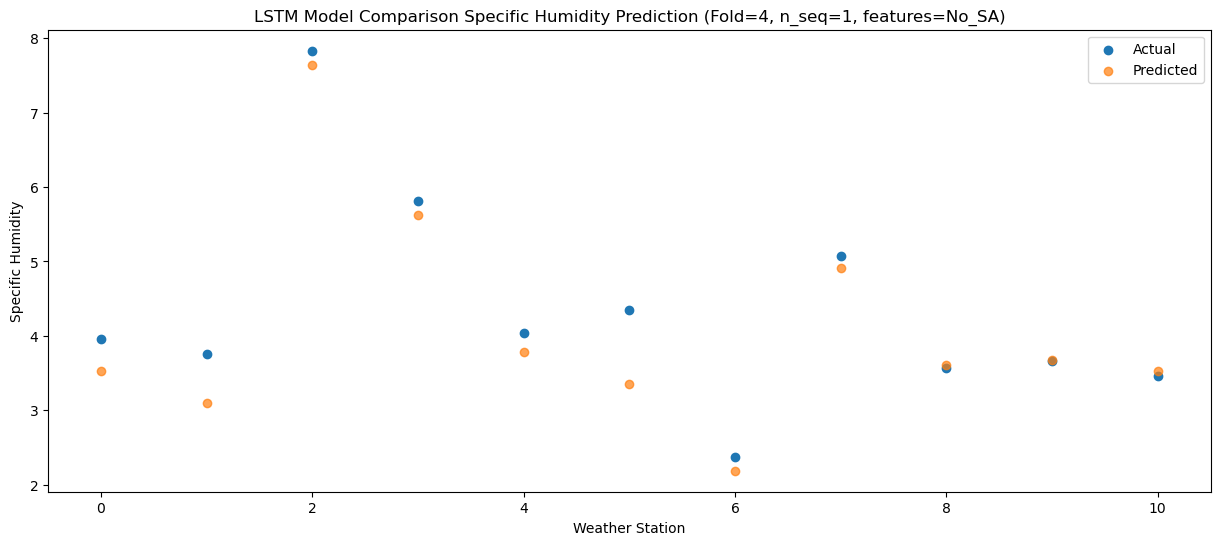

f, t:
[[3.96 3.75 7.83 5.81 4.04 4.35 2.37 5.07 3.57 3.66 3.46]]
[[3.53275731 3.09923672 7.6390163  5.62068401 3.78134819 3.3529134
  2.1885068  4.91704598 3.61466865 3.67356072 3.53440085]]
Year at t+1:
t+1 SKRMSE: 0.404910
t+1 KRMSE: 0.404910
t+1 MAE: 0.289193
t+1 SKMAPE: 0.070555
t+1 R2_SCORE: 0.914792
t+1 KMAPE: 0.070555
t+1 PEARSON: 0.952948
t+1 AVERAGE ACTUAL: 4.351818
Metrics for this Fold:
SKRMSE: 0.404910
KRMSE: 0.404910
MAE: 0.289193
SKMAPE: 0.070555
R2_SCORE: 0.914792
KMAPE: 0.070555
PEARSON: 0.952948
AVERAGE ACTUAL: 4.351818
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (1, 1, 512)               5083136   
                                                                 
 dropout_8 (Dropout)         (1, 1, 512)               0         
                                                                 
 lstm_9 (LSTM)               (1, 512)  

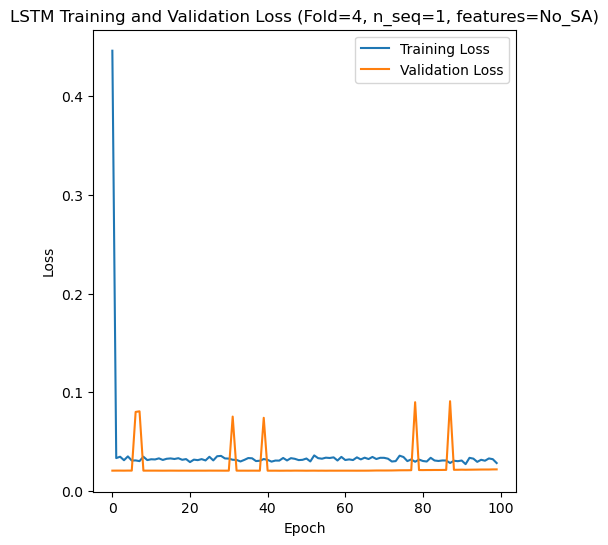

[[0.41836664702755294], [0.6403407687818107], [0.6056422536726396], [0.5622174075153777], [0.4049103493667607]]
[[array(0.41836665)], [array(0.64034077)], [array(0.60564225)], [array(0.56221741)], [array(0.40491035)]]
[[0.33402570377696633], [0.5565889668464662], [0.5216779647090217], [0.4698554279858414], [0.28919286370277414]]
[[0.058121110018101454], [0.1373874556846615], [0.13049604610756205], [0.1290602252408911], [0.07055532669033837]]
[[0.9203698373056055], [0.865287296530542], [0.8345220442685009], [0.5352115485182505], [0.9147919548823656]]
[[array(0.05812111)], [array(0.13738746)], [array(0.13049605)], [array(0.12906023)], [array(0.07055533)]]
[[array(0.9786125)], [array(0.95612624)], [array(0.98322099)], [array(0.81878768)], [array(0.95294834)]]
[3.9  5.74 8.41 5.55 7.36 4.02 6.35 4.55 4.32 4.11 3.76 2.59 6.45 5.07
 5.43 6.41 7.16 2.41 4.68 4.48 3.26 1.64 4.83 4.92 2.95 7.7  3.82 7.31
 6.   4.9  2.74 4.92 5.07 3.58 5.02 4.17 5.29 3.79 3.62 4.35 2.5  3.4
 4.84 3.02 3.96 3.75 

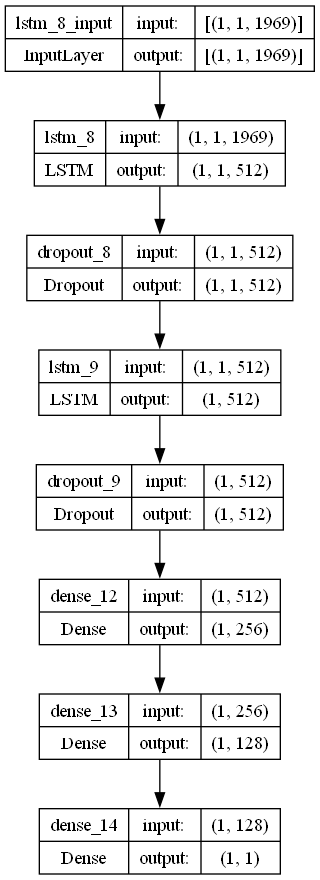

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from best model
    lr = 0.0010318332218166126
    optimizer = SGD(learning_rate = lr)
    activation_function = 'sigmoid'
    lstm_units = 512
    dropout_rate = 0.18976474581381156

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))
    
    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()

    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S1_No_SA.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)